# CS909 Data Mining Assignment 2

Importing the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load file

In [2]:
X = np.load("data\images.npy")  #read images
Y = pd.read_csv('data\counts.csv')  #read cell counts
F = np.loadtxt('data\split.txt')  #read fold information


## **Question No. 1: (Data Analysis) [20 Marks]**

**i. How many examples are there in each fold? [2 marks]**

In [3]:
first_fold = []
second_fold = []
third_fold = []
for index in range(len(F)):
    item = F[index]
    if item == 1:
        first_fold.append(index)
    elif item == 2:
        second_fold.append(index)
    elif item == 3:
        third_fold.append(index)

print("The number of examples in first_fold", len(first_fold))
print("The number of examples in second_fold", len(second_fold))
print("The number of examples in third_fold", len(third_fold))


The number of examples in first_fold 1622
The number of examples in second_fold 1751
The number of examples in third_fold 1608


**ii. Show some image examples using plt.imshow. Describe your observations on what you
see in the images and how it correlates with the cell counts of different types of cells and the
overall number of cells. [2 marks]**

In the first fold, these picture have more "epithelial" cell compared with other cell type, but the rate of "connective" cell is also large than other folds. Besides, these picture includs a lot of type of cells.

In the second fold, the rate of "lymphocyte" cell is larger than other folds, but the number of cell in picture from this fold is few than other folds. In addition, pictures from this fold may have more "neutrophil" cells, which is not existing in other folds. 

In the third fold, the number of "epithelial" cells is larger more than other cells, the numbers of rest types is near 0. Besides, the color of picture is similar to purple. Therefore, the color of image will be important factor when I apply the trained model to test dataset.

First_fold
136


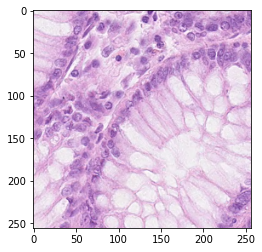

neutrophil     0
epithelial    54
lymphocyte     4
plasma         7
eosinophil     0
connective    12
Name: 136, dtype: int64
137


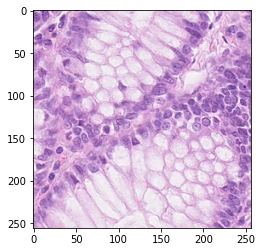

neutrophil     0
epithelial    95
lymphocyte     2
plasma         4
eosinophil     0
connective     5
Name: 137, dtype: int64
138


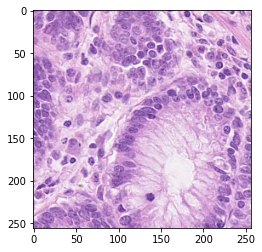

neutrophil      0
epithelial    101
lymphocyte     14
plasma         13
eosinophil      3
connective     25
Name: 138, dtype: int64
139


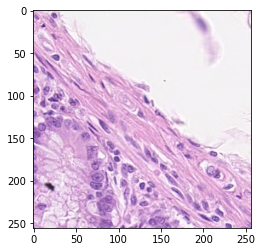

neutrophil     0
epithelial    14
lymphocyte     7
plasma         3
eosinophil     1
connective    34
Name: 139, dtype: int64
140


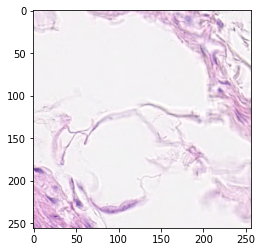

neutrophil    0
epithelial    0
lymphocyte    0
plasma        0
eosinophil    0
connective    2
Name: 140, dtype: int64
Second_fold
280


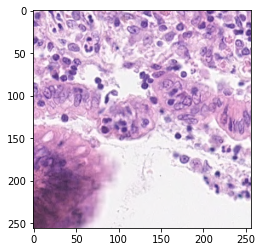

neutrophil     1
epithelial    26
lymphocyte    30
plasma         5
eosinophil     0
connective    22
Name: 280, dtype: int64
281


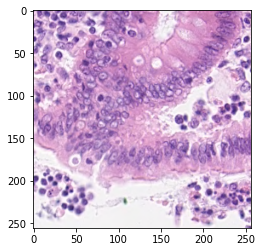

neutrophil     3
epithelial    88
lymphocyte    31
plasma         2
eosinophil     0
connective    14
Name: 281, dtype: int64
282


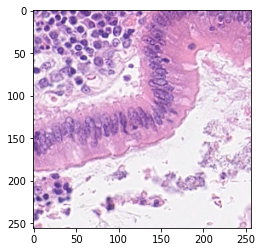

neutrophil     0
epithelial    32
lymphocyte    24
plasma         8
eosinophil     1
connective    16
Name: 282, dtype: int64
283


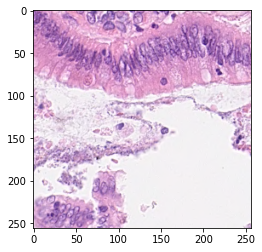

neutrophil     1
epithelial    44
lymphocyte     4
plasma         1
eosinophil     0
connective     4
Name: 283, dtype: int64
284


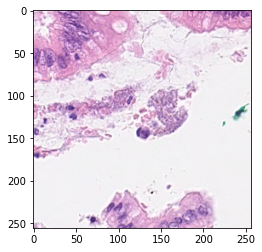

neutrophil     0
epithelial    11
lymphocyte     4
plasma         0
eosinophil     1
connective     0
Name: 284, dtype: int64
Third_fold
0


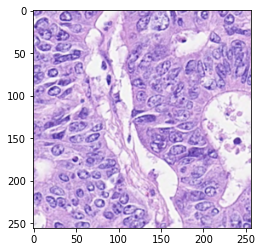

neutrophil      0
epithelial    117
lymphocyte      0
plasma          0
eosinophil      0
connective      0
Name: 0, dtype: int64
1


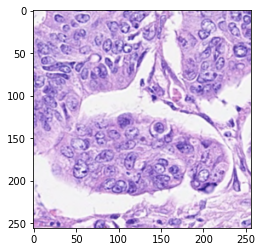

neutrophil     0
epithelial    95
lymphocyte     1
plasma         0
eosinophil     0
connective     8
Name: 1, dtype: int64
2


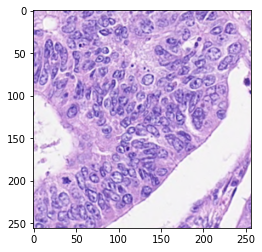

neutrophil      0
epithelial    172
lymphocyte      3
plasma          0
eosinophil      0
connective      2
Name: 2, dtype: int64
3


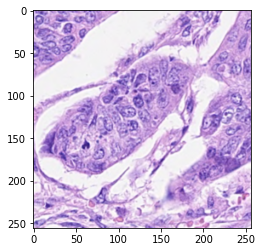

neutrophil     0
epithelial    56
lymphocyte     0
plasma         0
eosinophil     0
connective    10
Name: 3, dtype: int64
4


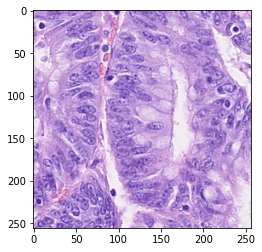

neutrophil      0
epithelial    169
lymphocyte      7
plasma          0
eosinophil      0
connective      0
Name: 4, dtype: int64


In [4]:
print("First_fold")
for index in range(5):
    print(first_fold[index])
    plt.imshow(X[first_fold[index]])
    plt.show()
    print(Y.iloc[first_fold[index]])
print("=====================================")
print("Second_fold")
for index in range(5):
    print(second_fold[index])
    plt.imshow(X[second_fold[index]])
    plt.show()
    print(Y.iloc[second_fold[index]])
print("=====================================")
print("Third_fold")
for index in range(5):
    print(third_fold[index])
    plt.imshow(X[third_fold[index]])
    plt.show()
    print(Y.iloc[third_fold[index]])
print("=====================================")

**iii.For each fold, plot the histogram of counts of each cell type separately as well as the total
number of cells (7 plots in total). How many images have counts within each of the following
bins? [4 marks]**

The counts of image in different bins will be shown on bottom of histogram.

In [5]:
first_fold_Y = Y.loc[first_fold]
second_fold_Y = Y.loc[second_fold]
third_fold_Y = Y.loc[third_fold]

In [6]:
# Plotting histograms
def plot_hist(data, title):
    plt.rcParams.update({'font.size': 12})  # Adjust the font size
    bins = []
    if (np.max(data) > 100):
        bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.max(data)]
    else:
        bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    fig, ax = plt.subplots(figsize=(6, 4)) 
    n, bins, patches = ax.hist(data, bins=bins, color='steelblue')  # Change colour
    ax.set_title('Distribution of ' + title + ' cell Counts') 
    ax.set_xlabel('Frequency')  # Add horizontal axis labels
    ax.set_ylabel('Count')  # Add vertical axis labels
    plt.grid()  # Add grid lines
    plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.1)  # Adjusting the layout
    plt.show()
    print('The number of images of each range:', [int(i) for i in n])


# Count the number of individual cells
def get_sum_cell_count(df):
    sum_by_row = df.sum(axis=1)
    T1 = df['neutrophil'].values.tolist()
    T2 = df['epithelial'].values.tolist()
    T3 = df['lymphocyte'].values.tolist()
    T4 = df['plasma'].values.tolist()
    T5 = df['eosinophil'].values.tolist()
    T6 = df['connective'].values.tolist()
    Total = sum_by_row.values.tolist()

    plot_hist(T1, 'T1')
    plot_hist(T2, 'T2')
    plot_hist(T3, 'T3')
    plot_hist(T4, 'T4')
    plot_hist(T5, 'T5')
    plot_hist(T6, 'T6')
    plot_hist(Total, 'Total')
    print("=====================================")
    return Total

The frequency of each range is the number of images in different counts ranges

first_fold


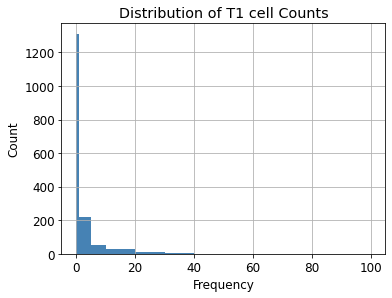

The number of images of each range: [1308, 218, 53, 30, 8, 4, 0, 1, 0, 0, 0, 0]


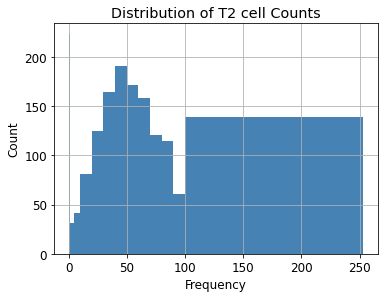

The number of images of each range: [223, 31, 41, 81, 125, 164, 191, 172, 158, 121, 115, 61, 139]


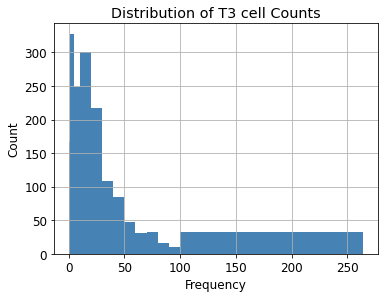

The number of images of each range: [166, 327, 249, 301, 217, 109, 84, 48, 31, 32, 16, 10, 32]


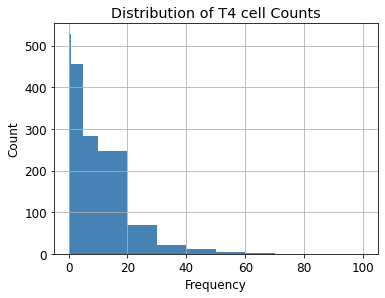

The number of images of each range: [527, 455, 284, 248, 70, 21, 12, 4, 1, 0, 0, 0]


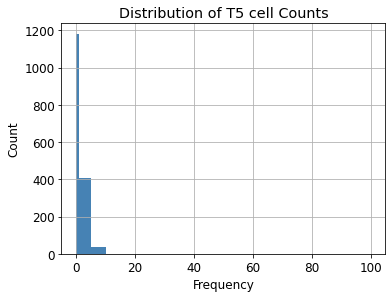

The number of images of each range: [1179, 408, 34, 1, 0, 0, 0, 0, 0, 0, 0, 0]


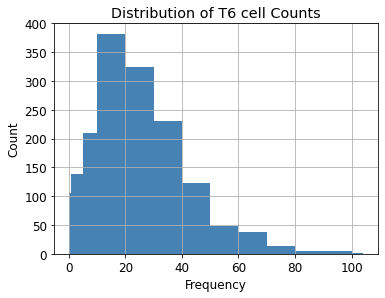

The number of images of each range: [105, 139, 209, 381, 324, 230, 123, 49, 38, 14, 4, 5, 1]


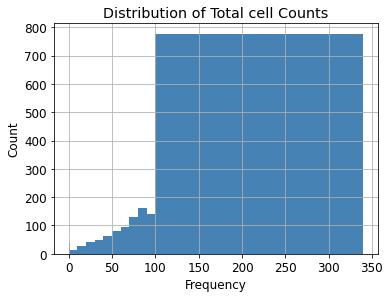

The number of images of each range: [39, 14, 14, 27, 40, 47, 62, 80, 93, 131, 160, 140, 775]
second_fold


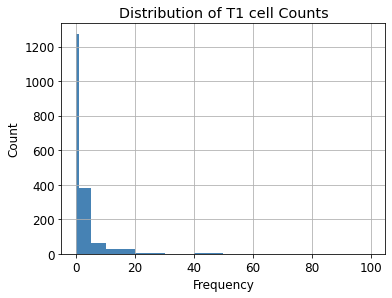

The number of images of each range: [1271, 380, 62, 30, 4, 1, 3, 0, 0, 0, 0, 0]


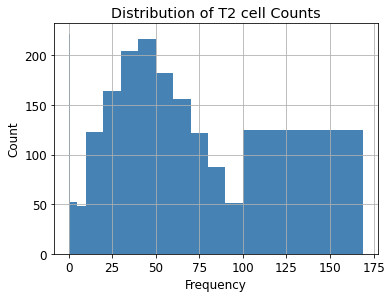

The number of images of each range: [221, 52, 48, 123, 164, 204, 216, 182, 156, 122, 87, 51, 125]


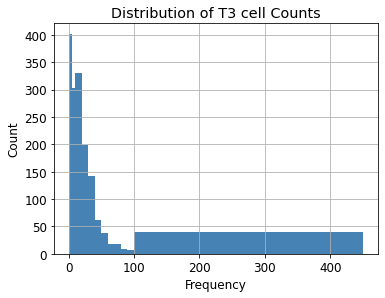

The number of images of each range: [185, 401, 303, 331, 198, 142, 61, 38, 18, 18, 9, 7, 40]


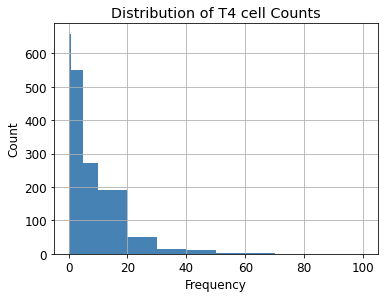

The number of images of each range: [657, 550, 273, 190, 51, 15, 11, 2, 2, 0, 0, 0]


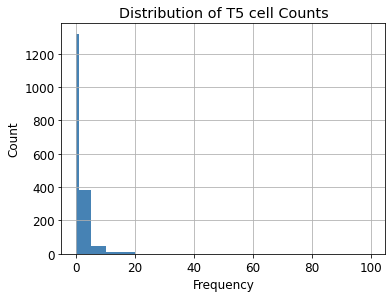

The number of images of each range: [1316, 380, 44, 10, 1, 0, 0, 0, 0, 0, 0, 0]


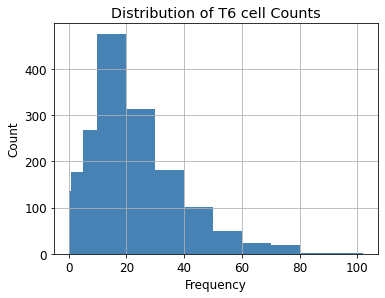

The number of images of each range: [135, 178, 269, 475, 313, 182, 102, 49, 24, 19, 2, 2, 1]


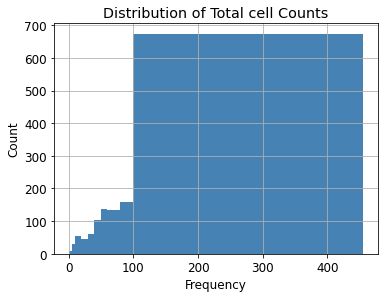

The number of images of each range: [54, 9, 30, 53, 44, 61, 105, 136, 135, 134, 158, 160, 672]
third_fold


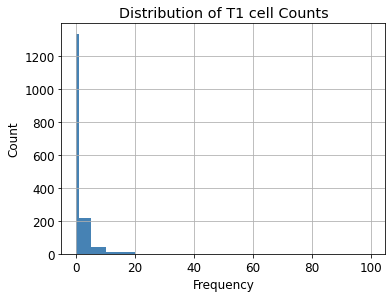

The number of images of each range: [1333, 218, 44, 13, 0, 0, 0, 0, 0, 0, 0, 0]


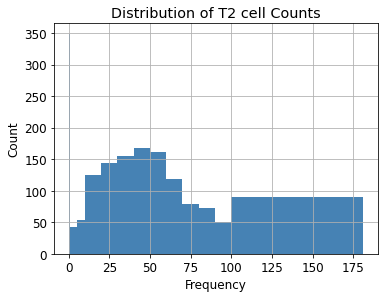

The number of images of each range: [348, 43, 54, 125, 144, 155, 168, 161, 119, 79, 72, 50, 90]


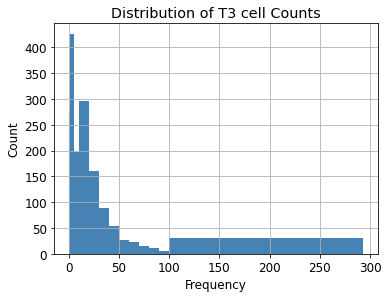

The number of images of each range: [274, 425, 198, 296, 160, 88, 54, 27, 23, 15, 12, 6, 30]


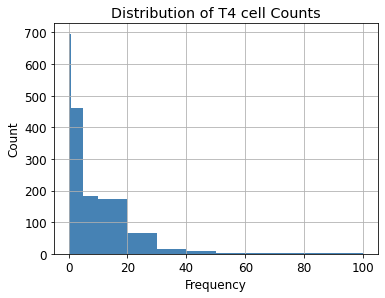

The number of images of each range: [694, 460, 182, 172, 67, 15, 9, 3, 3, 1, 1, 1]


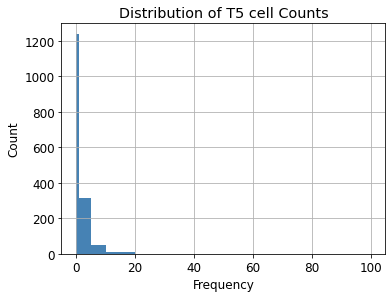

The number of images of each range: [1236, 315, 49, 8, 0, 0, 0, 0, 0, 0, 0, 0]


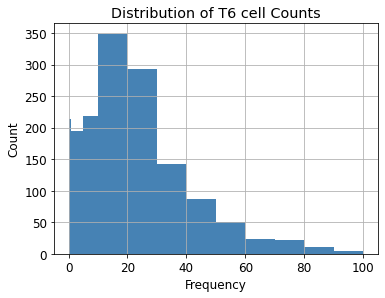

The number of images of each range: [214, 194, 219, 348, 293, 142, 87, 50, 23, 22, 11, 5]


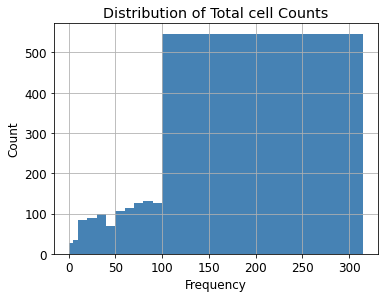

The number of images of each range: [57, 27, 34, 83, 89, 100, 69, 106, 114, 126, 132, 126, 545]


In [7]:
print("first_fold")
sum_by_row_first = get_sum_cell_count(first_fold_Y)
print("second_fold")
sum_by_row_second = get_sum_cell_count(second_fold_Y)
print("third_fold")
sum_by_row_third = get_sum_cell_count(third_fold_Y)


**iv. Pre-processing: Convert and show a few images from RGB space to HED space and show the H-channel which should indicate cellular nuclei. For this purpose, you can use the color separation notebook available here:https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html [5 marks]**

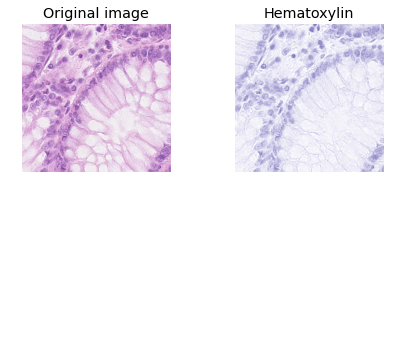

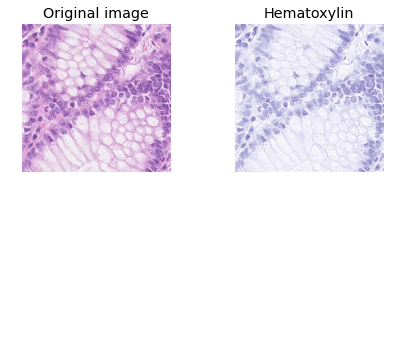

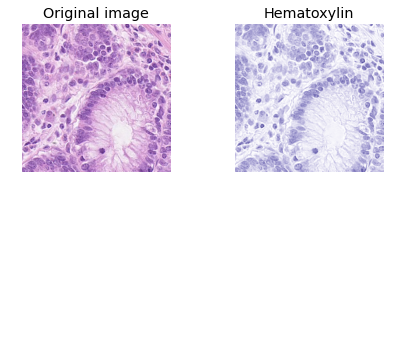

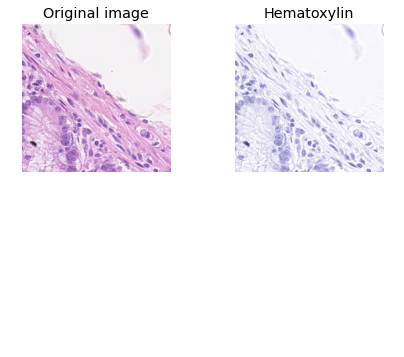

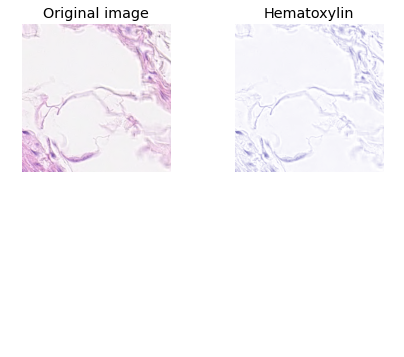

In [8]:
from skimage.color import rgb2hed, hed2rgb
import matplotlib.pyplot as plt
import numpy as np

for index in range(5):
    image = X[first_fold[index]]
    ihc_hed = rgb2hed(image)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))

    # Draw HED images
    fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image)
    ax[0].set_title("Original image")
    ax[1].imshow(ihc_h)
    ax[1].set_title("Hematoxylin")
    for a in ax.ravel():
        a.axis('off')
    plt.show()

**v. Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain type and the total number of cells for images in Fold-1 (7 plots in total). Do you think this feature would **be useful in your regression model?** Explain your reasoning. [4 marks]**

In [9]:
from scipy.stats import pearsonr

# Get the total number of cells per instance
sum_by_row = Y.sum(axis=1)
Total = sum_by_row.values.tolist()

sum_by_row.name = "total"

# Append Series to the end of a DataFrame
df = Y.join(sum_by_row)

first_fold_Y_al = df.loc[first_fold]
second_fold_Y_al = df.loc[second_fold]
third_fold_Y_al = df.loc[third_fold]

first_fold_Y_al = first_fold_Y_al.values.tolist()
second_fold_Y_al = second_fold_Y_al.values.tolist()
third_fold_Y_al = third_fold_Y_al.values.tolist()


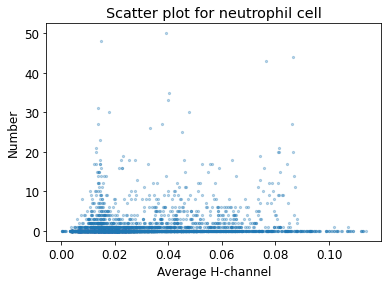

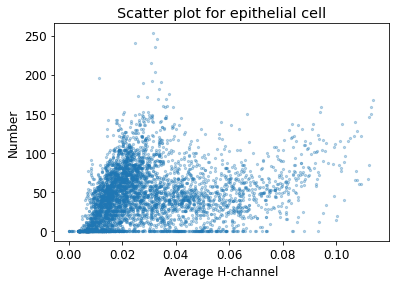

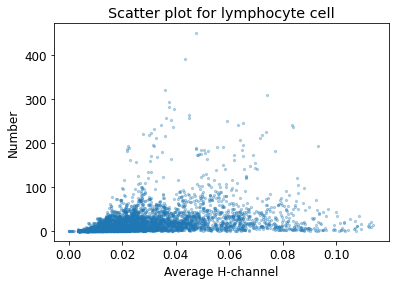

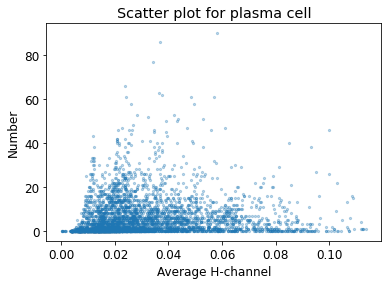

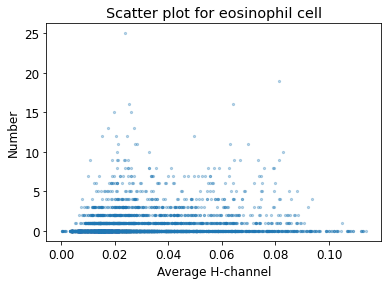

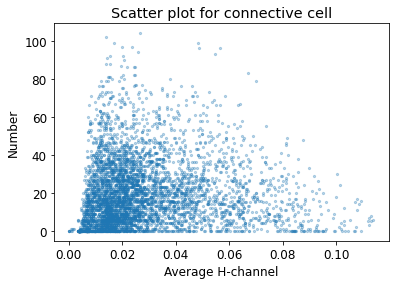

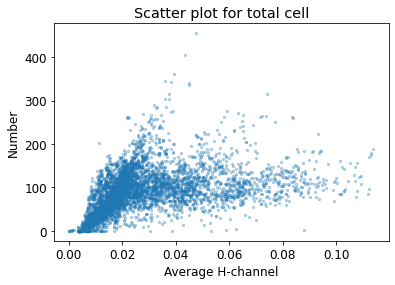

In [10]:
# get the average for each image in the H-channel
X_HED = np.array([rgb2hed(X[i]) for i in range(len(X))])
X_H = np.array([i[:, :, 0] for i in X_HED])

# Calculate the H average for each image
X_H_average = []
for index in X_H:
    average = np.mean(index)
    X_H_average.append(average)
X_H_average = np.array(X_H_average)

title = [
    "neutrophil", "epithelial", "lymphocyte", "plasma", "eosinophil",
    "connective", "total"
]
# plot the scatter plot

for name in title:
    plt.scatter(X_H_average, df[name], s=5, alpha=0.3, cmap='winter')
    plt.title("Scatter plot for " + name + " cell")
    plt.xlabel("Average H-channel")
    plt.ylabel("Number")
    plt.show()


From the results, there is a correlation between the final total cell number and the H channel. The mean of the H channel increases when the total cell number changes in. Therefore, the mean of H channel can be a useful feature to assist in determining the total cell number when making regression predictions.

Whereas the epithelial and connective cell types are similarly distributed, the number of cells is likely to be higher in the early stages when the mean value of the H channel is smaller, and the instances of higher cell numbers diminish as the mean value increases. So the mean value of the H channel can also be used to predict the number of cells in the above two categories.

The remaining cell numbers did not correlate with the H channel, and were small in any case, so this did not help their regression model.

**vi. What performance metrics can you use for this problem? Which one will be the best performance metric for this problem? Please give your reasoning. [3 marks]**

The following indicators are all possible performance indicators for the results of this forecast.

**Mean Squared Error (MSE):** It is the average of the sum of the squares of the differences between the predicted and actual values. a smaller MSE indicates a better fit of the model.

**Root Mean Squared Error (RMSE)**: This is the square root of the MSE and can therefore be seen as a magnification of the MSE; a smaller RMSE also indicates a better model performance.

**R2 score (R-squared)**: This is the ratio of the variance of the model's predicted values to the variance of the actual values; the closer the R2 score is to 1, the better the model performs.


The MSE and RMSE are both calculated by squaring the difference between the predicted value and the actual value. The squaring operation gives a larger error value at the point with a larger difference, which reflects a larger error compared to the other loss, which is important in a neural network to penalise larger prediction errors.

## **Question No. 2: (Feature Extraction and Classical Regression) [40 Marks]**

For the following questions, use the **total number of cells** as the output prediction variable.

i. Extract features from a given image. Specifically, calculate the:

a. average of the “H”, red, green and blue 

b. variance of the “H”, red, green and blue channels

c. Any other features that you think can be useful for this work. Describe your
reasoning for using these features.

Plot the scatter plot and calculate the correlation coefficient of each feature in Q(2i,a-c)
you obtain vs. the target variable (cell count) across all images. Which features do you
think are important? Give your reasoning.

In [11]:
# use only total number of cells as the prediction variable
sum_by_row = Y.sum(axis=1)
Total = sum_by_row.values

**Pre-processing**

Here are two ways to pre-process data

In [12]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def get_StandardScalered_data(Total):
    # Pre-processing using mean-standard deviation scaling
    scaler = StandardScaler().fit(Total)
    X_minmax = scaler.transform(Total)
    return X_minmax

def rescale_img(X):
    # Scale each feature by its maximum absolute value.
    Scaler = MaxAbsScaler()
    X_flat = np.array([img.ravel() for img in X]) # flatten the array for rescaling
    X_rescaled = Scaler.fit_transform(X_flat) # rescale the image data to range(-1,1)

    return X_rescaled

**Convert the image from RGB to HSV color space.** Then, I extract the "H" channel, as well as the red, green, and blue channels. 

In [13]:
from skimage import color

X_R = np.array([i[:, :, 0] for i in X])
X_G = np.array([i[:, :, 1] for i in X])
X_B = np.array([i[:, :, 2] for i in X])
X_H = np.array([color.rgb2hed(i)[:, :, 0] for i in X])


**Data process**

Removed this step because it didn't work well

In [14]:
# X_R=rescale_img(X_R)
# X_G=rescale_img(X_G)
# X_B=rescale_img(X_B)
# X_H=rescale_img(X_H)

**PCA**

In the following, PCA will be used to downscale the image to only one most important component, and this feature will be used as one of the features as input to the following regression model, along with other features such as X_R's average.

In [15]:
from sklearn.decomposition import PCA

# randomised PCA
def get_PCA(X):
    pca = PCA(n_components = 1, svd_solver = 'randomized')
    PCA_1 = pca.fit_transform(X)
    PCA_results = pd.DataFrame(PCA_1, columns = ['PCA'])
    
    return PCA_results

**Compute average, variance and Shannon entropy of the “H”, red, green and blue channels**

In addition to the four prescribed metrics, I have chosen Shannon entropy as a new metric.

Shannon entropy can be used as one of the meaningful features when extracting features from an image. Specifically, Shannon entropy can be used to describe the complexity or information content of an image and can therefore be used as a texture feature or visual quality evaluation metric for images. 

In [16]:
from skimage.measure import shannon_entropy

def get_feature(data):
    results = []
    for i in data:
        average = np.mean(i)
        variance = np.var(i)
        # Calculate the contrast of each channel
        entropy = shannon_entropy(i.ravel())
        # contrast = (np.max(i) - np.min(i)) / (np.max(i) + np.min(i))
        # results_dict = {"average": average, "variance": variance,"contrast": contrast}
        results_dict = {"average": average, "variance": variance,"entropy": entropy}
        results.append(results_dict)
    results = pd.DataFrame(results, dtype = float)
    return results

In [17]:
X_H_feature = get_feature(X_H)
X_R_feature = get_feature(X_R)
X_G_feature = get_feature(X_G)
X_B_feature = get_feature(X_B)

In [18]:
# get the PCA results for each channel

H_PCA = get_PCA(X_H_feature)
R_PCA = get_PCA(X_R_feature)
G_PCA = get_PCA(X_G_feature)
B_PCA = get_PCA(X_B_feature)

In [19]:
import seaborn as sns


def scatterplot(data, name, color):
        data = pd.DataFrame(data)
        cols = [i for i in data.columns]
        length = int(len(cols))
        if length > 1:
                fig, ax = plt.subplots(1, length, figsize=(length*6, 6))
                ax[0].set_ylabel('Cell Count')
                for i in range(length):
                        sns.scatterplot(x = data[cols[i]], y = Total, ax=ax[i], alpha = 0.3, color = color)
                        ax[i].set_title('Scatterplot for the ' + name + ' feature', fontsize = 13) 


**Plot the scatter plot**

The scatter plot below shows that, apart from H_features, the other features of R, G and B all have a similar shape distribution, which suggests that they may have some prior concern when used as features in the model's dataset, and there may be redundant information if all of them are used. If this redundant information is used to train the model, it may lead to overfitting of the model and thus reduce the generalization ability of the model.

Also, if the correlation between features is high, it may be difficult to analyse the contribution of each feature to the model prediction.

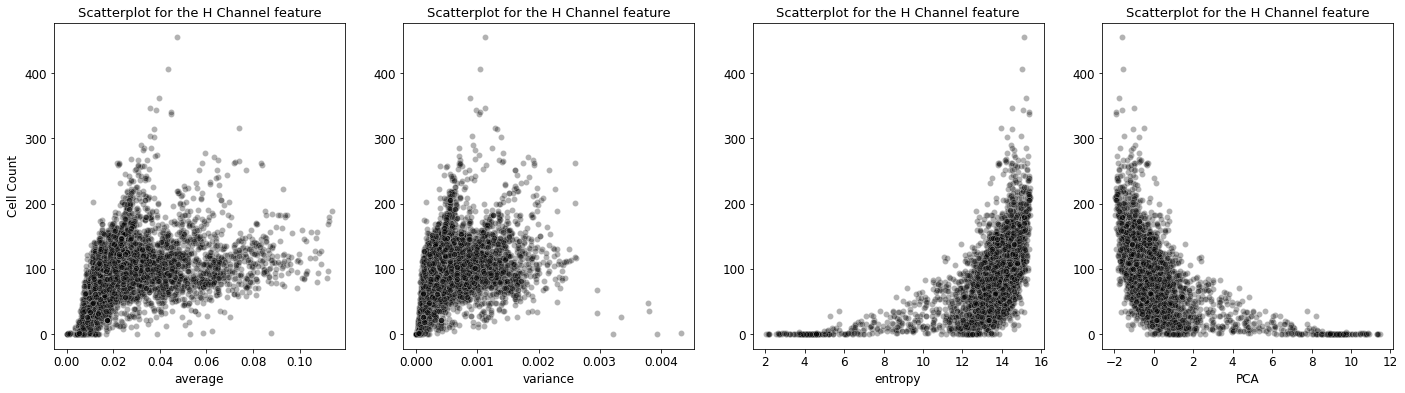

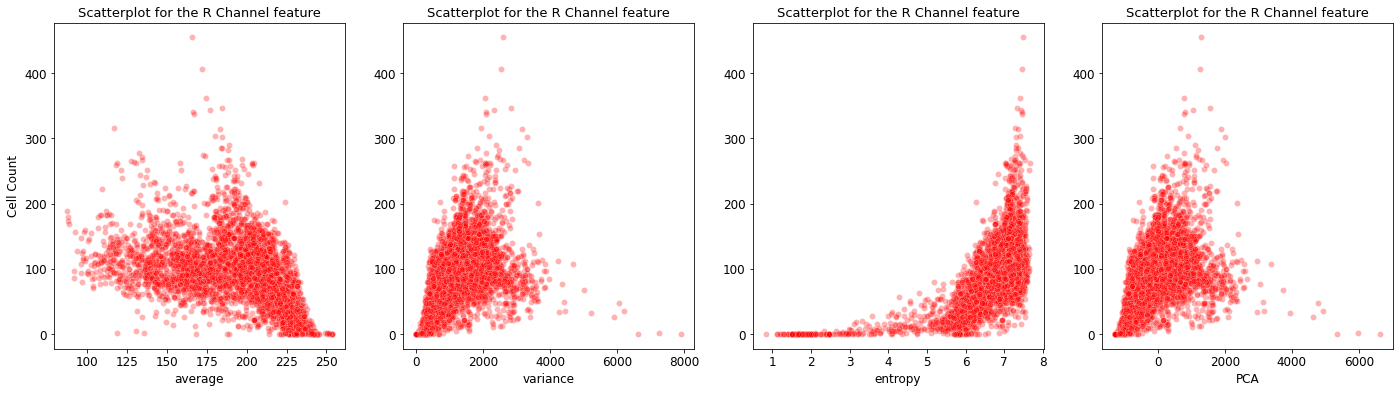

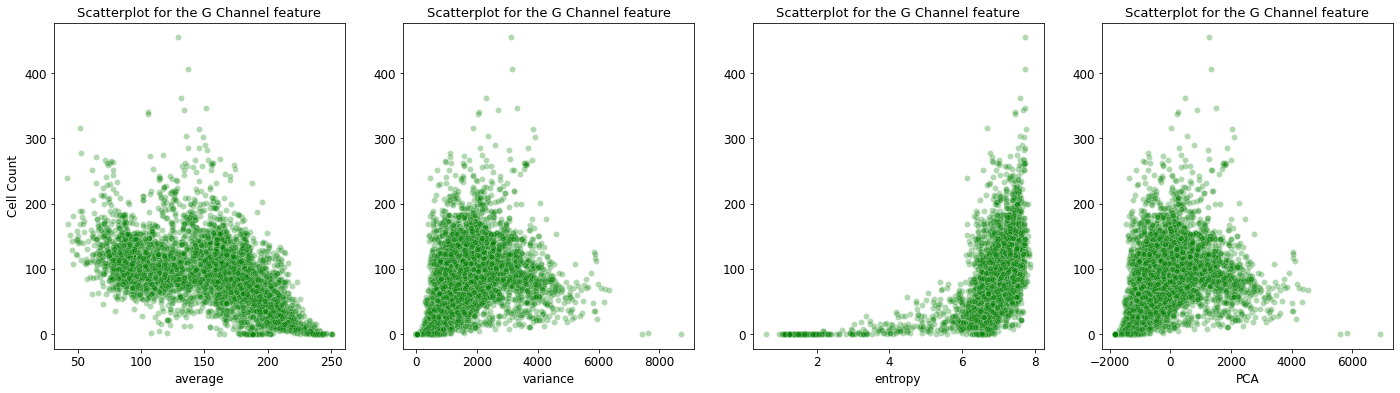

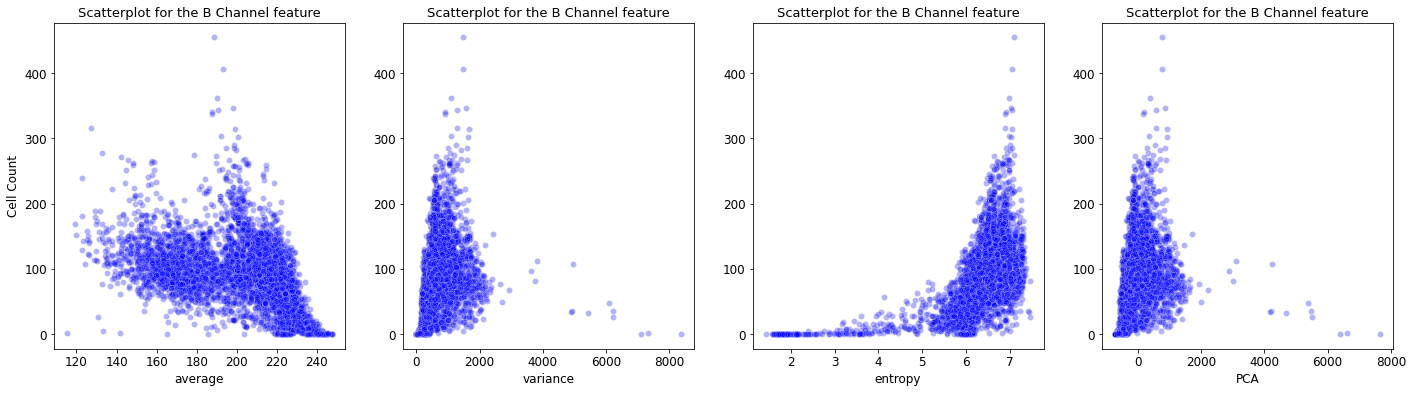

In [20]:
# plot the scatter plot for the average, variance, entropy features of each channel

H_features = pd.concat([X_H_feature, H_PCA], axis = 1)
R_features = pd.concat([X_R_feature, R_PCA], axis = 1)
G_features = pd.concat([X_G_feature, G_PCA], axis = 1)
B_features = pd.concat([X_B_feature, B_PCA], axis = 1)

scatterplot(H_features, 'H Channel', 'black')
scatterplot(R_features, 'R Channel', 'red')
scatterplot(G_features, 'G Channel', 'green')
scatterplot(B_features, 'B Channel', 'blue')

**Calculating correlation coefficient**

In [21]:
def compute_correlation(feature, Total,title):
    print(f"Correlation between {title} and total cell count")
    features = ['average', 'variance',"entropy","PCA"]
    average=0
    variance=0
    entropy=0
    pca=0
    # Calculate the correlation coefficient for each feature
    for col_name in features:
        r, p = pearsonr(feature[col_name], Total)
        print(f"{col_name}: Pearson correlation coefficient = {r:.3f}")
        if col_name=="average":
            average=r
        elif col_name=="variance":
            variance=r
        elif col_name=="entropy":
            entropy=r
        elif col_name=="PCA":
            pca=r
    print("=====================================")
    return average,variance,entropy,pca


In [22]:
H_average,H_variance,H_entropy,H_pca=compute_correlation(H_features, Total,'H-channel')
R_average,R_variance,R_entropy,R_pca=compute_correlation(R_features, Total,'R-channel')
G_average,G_variance,G_entropy,G_pca=compute_correlation(G_features, Total,'G-channel')
B_average,B_variance,B_entropy,B_pca=compute_correlation(B_features, Total,'B-channel')
average_list=[H_average,R_average,G_average,B_average]
variance_list=[H_variance,R_variance,G_variance,B_variance]
entropy_list=[H_entropy,R_entropy,G_entropy,B_entropy]
pca_list=[H_pca,R_pca,G_pca,B_pca]

Correlation between H-channel and total cell count
average: Pearson correlation coefficient = 0.429
variance: Pearson correlation coefficient = 0.423
entropy: Pearson correlation coefficient = 0.543
PCA: Pearson correlation coefficient = -0.543
Correlation between R-channel and total cell count
average: Pearson correlation coefficient = -0.487
variance: Pearson correlation coefficient = 0.456
entropy: Pearson correlation coefficient = 0.601
PCA: Pearson correlation coefficient = 0.456
Correlation between G-channel and total cell count
average: Pearson correlation coefficient = -0.572
variance: Pearson correlation coefficient = 0.221
entropy: Pearson correlation coefficient = 0.505
PCA: Pearson correlation coefficient = 0.221
Correlation between B-channel and total cell count
average: Pearson correlation coefficient = -0.472
variance: Pearson correlation coefficient = 0.242
entropy: Pearson correlation coefficient = 0.537
PCA: Pearson correlation coefficient = 0.242


The absolute values of the correlation coefficient are high for H's entropy and PCA, R's entropy, G's average and entropy, and B's entropy.

As it can be seen, the values of entropy are high, which should be meaningful for classification. In the following I will extract these features as input values for the regression model

**ii. Try the following regression models with the features used in part-I. Plot the scatter plot between true and predicted counts for each type of regression model for the test data. Also, report your prediction performance in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) on the test data. [20 Marks]**

The first_fold and second_flod are used here as the training set, while the third_fold is used here as the test set, as the first_fold is used as the training set and the model has poorer metrics, while the training set has better metrics when the amount of data is increased. So to be able to get a better model, the development dataset here was merged into the training dataset.

In the following, the attributes with higher relevance mentioned in I part are merged into a dataframe for training.

In [23]:
def getDataset():
    feature1=R_features["entropy"]
    feature2=H_features["entropy"]
    feature3=G_features["entropy"]
    feature4=B_features["entropy"]
    feature5=G_features["average"]
    feature6=H_features["average"]
    dataset=pd.concat([feature1,feature2,feature3,feature4,feature5,feature6], axis=1)
    dataset = pd.DataFrame(dataset)
    dataset.columns = ['R_entropy', 'H_entropy', 'G_entropy', 'B_entropy', 'G_average', 'H_PCA']
    return dataset
Total_dataset=getDataset()
first_fold_Feature_dataset=Total_dataset.iloc[first_fold]
second_fold_Feature_dataset=Total_dataset.iloc[second_fold]
third_fold_Feature_dataset=Total_dataset.iloc[third_fold]

In [24]:
# Merge training datasets
train_dataset=first_fold_Feature_dataset.append(second_fold_Feature_dataset)

In [25]:
sum_by_row_1 = first_fold_Y.sum(axis=1)
Total_train = sum_by_row_1.values.tolist()

sum_by_row_2 = second_fold_Y.sum(axis=1)
Total_dev = sum_by_row_2.values.tolist()

sum_by_row_3 = third_fold_Y.sum(axis=1)
Total_test = sum_by_row_3.values.tolist()

In [26]:
# Combined test labels
train_label=Total_train+Total_dev

**Conclusion**

**Metric analysis**

The following analysis was performed by taking the best performing of the three models for each cell type.

1. The overall cell count was predicted better：

The RMSE was 38.3844, indicating a degree of error between the model prediction and the actual value, but because the overall cell count was larger for each image, the RMSE may also be on the large side, which is acceptable.

The Pearson Correlation Coefficient was 0.6819, indicating a positive and strong linear relationship between the predicted and actual values.

The R² of 0.4650 indicates that the model explains about 46.50% of the variance in the actual values, but the model is still not a good fit for the data.

The Spearman Correlation Coefficient was 0.7235, indicating a strong positive monotonic relationship between predicted and actual values.

2. A cross-sectional comparison of the number identification effects of different cell types.

The final prediction was found to be poor for neutrophil, eosinophil and connective types, while better for epithelial, lymphocyte and plasma types. Also there was a pattern in the final metrics in that the Spearman correlation coefficient was higher relative to the others, indicating that the model performed better in capturing monotonic relationships, but the Pearson correlation coefficient and R² were both lower, possibly implying that the model fitted non-linear relationships less well.

Other than that, for all that needs to be predicted, the optimal models are generally SVC and MLPRegressor.

**Plot analysis**

The scatter plot distribution shows that most of the predictions are similar to the true distribution, i.e. the approximate range predicted by the model is between 0 and 80, while most of the predictions are concentrated in the 0-40 interval. The true counts are different, and there can even be as many as 300 cells of that species in a single image, but such cases are less common and these can be judged as outlier.

**Parameters adjustment**

The models below have all been adjusted for hyperparameters using GridSearchCV. To save space on the page, I have only kept a record of the first time each model was tuned to show the parameters I set and the range of choices.

## The regression model of total cell number

### A. Ordinary Least Squares (OLS) regression

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# # Set the list of parameters to be optimised
# params_grid={'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
# lr = LinearRegression()

# # Cross-validation of models using GridSearchCV
# Grid_search = GridSearchCV(lr, params_grid)
# Grid_search.fit(train_dataset, train_label)

# Grid_search.best_score_
# Grid_search.best_params_
# Grid_search.best_estimator_

# # Print optimal parameters
# print(Grid_search.best_score_)
# print(Grid_search.best_params_)
# print(Grid_search.best_estimator_)

In [28]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=False)
# Fitting the model
model.fit(train_dataset, train_label)

LinearRegression(fit_intercept=False)

In [29]:
y_pred = model.predict(third_fold_Feature_dataset)

**RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score**

The smaller the RMSE the better, the closer the Pearson Correlation Coefficient (PCC) to 1 the better, the closer the R2 to 1 the better, the closer the SCC (Spearman Correlation Coefficient) to 1 the better

In [30]:
from scipy.stats import spearmanr

def getAllmertic(y_pred,y_true):
    # Calculation of mean squared error MSE
    mse = np.mean((y_true - y_pred) ** 2)  
    # Calculation of Root Mean Square Error RMSE
    rmse = np.sqrt(mse) 
    # Pearson Correlation Coefficient
    pcc = np.corrcoef(y_true, y_pred)[0, 1]
    # R2
    r2 = pcc ** 2
    # Spearman Correlation Coefficient
    corr, pval = spearmanr(y_pred, y_true)

    print("RMSE: ", rmse)
    print("Pearson Correlation Coefficient: ", pcc)
    print("R2: ", r2)
    print("Spearman Correlation Coefficient: ", corr)
    # return rmse,pcc,r2,corr

In [31]:
getAllmertic(y_pred,Total_test)

RMSE:  38.38444158981868
Pearson Correlation Coefficient:  0.6818799923711268
R2:  0.464960323996048
Spearman Correlation Coefficient:  0.7234918558904017


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

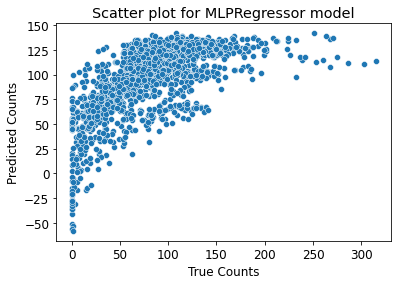

In [32]:
sns.scatterplot(Total_test, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

The result before the image was processed with MaxAbsScaler:

| Metric                          | Value                 |
|---------------------------------|-----------------------|
| RMSE                            | 38.15524431386757     |
| Pearson Correlation Coefficient | 0.6801819359904023    |
| R2                              | 0.4626474660476518    |
| Spearman Correlation Coefficient| 0.7234918558904017    |



The results of the treatment, which did not make much difference, even decreased, so that no pre-treatment was carried out.


| Metric                          | Value                 |
|---------------------------------|-----------------------|
| Root Mean Squared Error (RMSE)  | 36.46236446515516     |
| Pearson Correlation Coefficient | 0.682572722755678     |
| R-squared (R2)                  | 0.4390026129398726    |
| Spearman Correlation Coefficient| 0.6924480419663669    |

### B. Support Vector Regression

Support Vector Regression is a Support Vector Machine (SVM) based regression method for predicting continuous type variables. It is a non-linear regression method that can handle non-linear relationships and still perform well in the presence of noise or outliers in the training data.

Best parameters:  {'C': 10, 'kernel': 'linear'}

In [33]:
# model_SVR = SVR()

# # Set the list of parameters to be optimised
# param_grid = {
#     "C": [0.1, 1, 10, 100],
#     "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
# }

# # Cross-validation of models using GridSearchCV
# grid_search = GridSearchCV(model_SVR, param_grid, cv=5)
# grid_search.fit(train_dataset, train_label)

# # Print optimal parameters
# print("Best parameters: ", grid_search.best_params_)

In [34]:
svr = SVR(C=10, epsilon=0.1,kernel='linear')
svr.fit(train_dataset, train_label)
y_pred = svr.predict(third_fold_Feature_dataset)

In [35]:
getAllmertic(y_pred,Total_test)

RMSE:  38.62760181790313
Pearson Correlation Coefficient:  0.642124027552782
R2:  0.4123232667606059
Spearman Correlation Coefficient:  0.6841785919354422


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

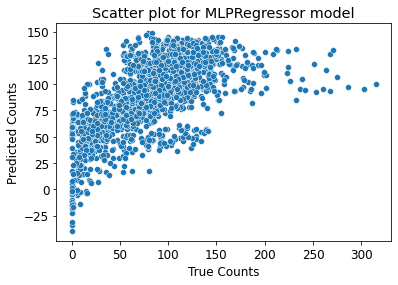

In [36]:
sns.scatterplot(Total_test, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

The results before image processing are not included:


| Metric                          | Value                 |
|---------------------------------|-----------------------|
| RMSE                            | 37.12911224556065     |
| Pearson Correlation Coefficient | 0.6710582013988392    |
| R2                              | 0.45031910966464506   |
| Spearman Correlation Coefficient| 0.7117048104994206    |


Result after processing:

| Metric                          | Value                 |
|---------------------------------|-----------------------|
| Root Mean Squared Error (RMSE)  | 37.46236446215516     |
| Pearson Correlation Coefficient | 0.662572722755678     |
| R-squared (R2)                  | 0.4390026129398726    |
| Spearman Correlation Coefficient| 0.7024480419663669    |



### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'relu', 'batch_size': 8, 'learning_rate': 'constant'}

In [37]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV

# model_MLPRegressor = MLPRegressor()

# # Set the list of parameters to be optimised
# param_grid = {
#     "learning_rate": ["constant", "invscaling", "adaptive"],
#     "activation": ['identity', 'logistic', 'tanh', 'relu'],
#     "batch_size":[4,8,32,64]
# }

# # Cross-validation of models using GridSearchCV
# grid_search = GridSearchCV(model_MLPRegressor, param_grid, cv=5)
# grid_search.fit(train_dataset, train_label)

# # Print optimal parameters
# print("Best parameters: ", grid_search.best_params_)

In [38]:
from sklearn.neural_network import MLPRegressor

# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='constant', batch_size=8, learning_rate_init=0.001)


# Training models
mlp.fit(train_dataset, train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,Total_test)

RMSE:  35.52268137813006
Pearson Correlation Coefficient:  0.7185416068178365
R2:  0.5163020407283584
Spearman Correlation Coefficient:  0.75139141790936


Although MLPRegressor performs best and has better performance after image processing. But in practice the performance of several models is not very different.

Before processing:

| Metric                          | Value                 |
|---------------------------------|-----------------------|
| RMSE                            | 36.52969789395134     |
| Pearson Correlation Coefficient | 0.7057367290118098    |
| R2                              | 0.4980643306762887    |
| Spearman Correlation Coefficient| 0.7259717405676056    |


After processing:

| Metric                          | Value                 |
|---------------------------------|-----------------------|
| Root Mean Squared Error (RMSE)  | 35.27668478679617     |
| Pearson Correlation Coefficient | 0.7088307221238161    |
| R-squared (R2)                  | 0.5024409926265707    |
| Spearman Correlation Coefficient| 0.7423527321528125    |


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

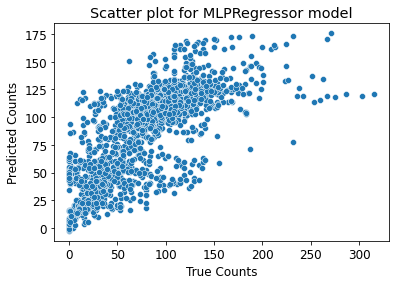

In [39]:
sns.scatterplot(Total_test, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

## The regression model of T1 cell

### A. Ordinary Least Squares (OLS) regression

Extract the label of the data set for the six cell types

T1: neutrophil , T2: epithelial T3: lymphocyte, T4: plasma , T5: eosinophil and T6: connective

In [40]:
def process_cell_train_label(type):
    T_1=first_fold_Y[type].tolist()
    T_2=second_fold_Y[type].tolist()
    T_train_label=T_1+T_2
    T_test_label=third_fold_Y[type].tolist()
    return T_train_label,T_test_label

T1_train_label,T1_test_label=process_cell_train_label("neutrophil")
T2_train_label,T2_test_label=process_cell_train_label("epithelial")
T3_train_label,T3_test_label=process_cell_train_label("lymphocyte")
T4_train_label,T4_test_label=process_cell_train_label("plasma")
T5_train_label,T5_test_label=process_cell_train_label("eosinophil")
T6_train_label,T6_test_label=process_cell_train_label("connective")

In [41]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=False)
# Fitting the model
model.fit(train_dataset, T1_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T1_test_label)

RMSE:  1.7059426001718616
Pearson Correlation Coefficient:  0.2022460591441531
R2:  0.04090346843934028
Spearman Correlation Coefficient:  0.2199639262892623


### B. Support Vector Regression

Best parameters:  {'C': 100, 'kernel': 'linear'}

In [42]:
svr = SVR(C=100, epsilon=0.1,kernel='linear')
svr.fit(train_dataset, T1_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T1_test_label)

RMSE:  1.6998197362481104
Pearson Correlation Coefficient:  0.12234157926815858
R2:  0.014967462017827131
Spearman Correlation Coefficient:  0.17484596248698697


### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'tanh', 'batch_size': 4, 'learning_rate': 'constant'}

In [43]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam', learning_rate='constant', batch_size=4, learning_rate_init=0.001)

# Training models
mlp.fit(train_dataset, T1_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T1_test_label)

RMSE:  1.6399276132009815
Pearson Correlation Coefficient:  0.23034011825830605
R2:  0.053056570079250416
Spearman Correlation Coefficient:  0.2400870110106711


The one that works best is **MLPRegressor()**

The result is


| Evaluation Metric                      |     Score |
|:--------------------------------------|----------:|
| Root Mean Square Error (RMSE)          | 1.72945   |
| Pearson Correlation Coefficient        | 0.258289  |
| R2 Score                               | 0.0667132 |
| Spearman Correlation Coefficient       | 0.254108  |


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

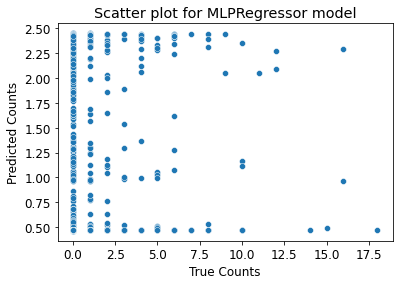

In [44]:
sns.scatterplot(T1_test_label, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

## The regression model of T2 cell

### A. Ordinary Least Squares (OLS) regression

{'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [45]:
# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
# Fitting the model
model.fit(train_dataset, T1_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T1_test_label)

RMSE:  1.710202731100624
Pearson Correlation Coefficient:  0.1983092468915411
R2:  0.039326557402690206
Spearman Correlation Coefficient:  0.21646671694495492


### B. Support Vector Regression

{'C': 100, 'kernel': 'linear'}

In [46]:
svr = SVR(C=100, epsilon=0.1,kernel='linear')
svr.fit(train_dataset, T2_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T2_test_label)

RMSE:  30.28044084302694
Pearson Correlation Coefficient:  0.47584331786316614
R2:  0.22642686315502616
Spearman Correlation Coefficient:  0.5036886518433952


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

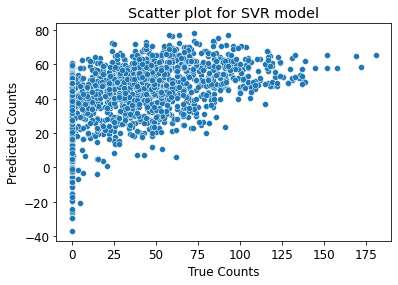

In [47]:
sns.scatterplot(T2_test_label, y_pred).set(title = 'Scatter plot for SVR model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'logistic', 'batch_size': 4, 'learning_rate': 'invscaling'}

In [48]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='logistic', solver='adam', learning_rate='invscaling', batch_size=8, learning_rate_init=0.001)


# Training models
mlp.fit(train_dataset, T2_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T2_test_label)

RMSE:  30.888032594365978
Pearson Correlation Coefficient:  0.48587161941191387
R2:  0.23607123054995569
Spearman Correlation Coefficient:  0.4823891501518269


C:\Users\hongj\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For this cell type, the optimal model is Support Vector Regression
| Evaluation Metric                 |      Score |
|:---------------------------------|-----------:|
| RMSE                              |  30.280441 |
| Pearson Correlation Coefficient  |   0.475843 |
| R2                                |   0.226427 |
| Spearman Correlation Coefficient |   0.503689 |



## The regression model of T3 cell

### A. Ordinary Least Squares (OLS) regression

{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [49]:
# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=True)
# Fitting the model
model.fit(train_dataset, T3_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T3_test_label)

RMSE:  27.621372744795963
Pearson Correlation Coefficient:  0.39241710883773506
R2:  0.1539911873085668
Spearman Correlation Coefficient:  0.6261569818063147


### B. Support Vector Regression

Best parameters:  {'C': 0.1, 'kernel': 'linear'}

In [50]:
svr = SVR(C=0.1, epsilon=0.1,kernel='linear')
svr.fit(train_dataset, T3_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T3_test_label)

RMSE:  27.681136861883857
Pearson Correlation Coefficient:  0.3744555951609658
R2:  0.14021699274735314
Spearman Correlation Coefficient:  0.6201016777690608


### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'relu', 'batch_size': 32, 'learning_rate': 'constant'}

In [51]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='constant', batch_size=32, learning_rate_init=0.001)

# Training models
mlp.fit(train_dataset, T3_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T3_test_label)

RMSE:  27.032986371710848
Pearson Correlation Coefficient:  0.4673838299250304
R2:  0.21844764447538975
Spearman Correlation Coefficient:  0.6822278162598603


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

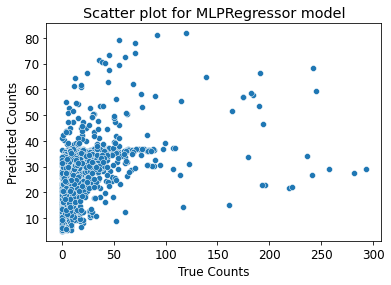

In [52]:
sns.scatterplot(T3_test_label, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

The best model is MLPRegressor

| Evaluation Metric                 |      Score |
|:---------------------------------|-----------:|
| RMSE                              |  26.46894347421835 |
| Pearson Correlation Coefficient  |   0.45774653167288487 |
| R2                                |   0.2095318872585554 |
| Spearman Correlation Coefficient |   0.6639554701965754 |


## The regression model of T4 cell

### A. Ordinary Least Squares (OLS) regression

{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [53]:
# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=True)
# Fitting the model
model.fit(train_dataset, T4_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T4_test_label)

RMSE:  8.700917838548351
Pearson Correlation Coefficient:  0.12283664436105242
R2:  0.015088841197883672
Spearman Correlation Coefficient:  0.314111804284034


### B. Support Vector Regression

Best parameters:  {'C': 100, 'kernel': 'rbf'}

In [54]:
svr = SVR(C=100, epsilon=0.1,kernel='rbf')
svr.fit(train_dataset, T4_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T4_test_label)

RMSE:  8.62747659582072
Pearson Correlation Coefficient:  0.2173822445059086
R2:  0.047255040226426626
Spearman Correlation Coefficient:  0.42147066330099914


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

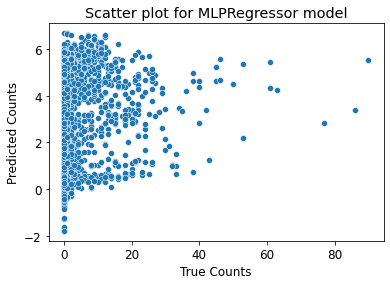

In [55]:
sns.scatterplot(T4_test_label, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'logistic', 'batch_size': 32, 'learning_rate': 'constant'}

In [56]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='logistic', solver='adam', learning_rate='constant', batch_size=32, learning_rate_init=0.001)

# Training models
mlp.fit(train_dataset, T4_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T4_test_label)

RMSE:  8.487594763163083
Pearson Correlation Coefficient:  0.22109057939756585
R2:  0.04888104429835137
Spearman Correlation Coefficient:  0.35325941408277267


The best model is Support Vector Regression

| Evaluation Metric                 |     Score |
|:---------------------------------|----------:|
| RMSE                              |  8.627477 |
| Pearson Correlation Coefficient  |  0.217382 |
| R2                                |  0.047255 |
| Spearman Correlation Coefficient |  0.421471 |


## The regression model of T5 cell

### A. Ordinary Least Squares (OLS) regression

{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [57]:
# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=False, normalize=True)
# Fitting the model
model.fit(train_dataset, T5_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T5_test_label)

RMSE:  1.554401939345855
Pearson Correlation Coefficient:  0.2171414941843078
R2:  0.04715042849659378
Spearman Correlation Coefficient:  0.3142421801017467


### B. Support Vector Regression

Best parameters:  {'C': 100, 'kernel': 'linear'}

In [58]:
svr = SVR(C=10,kernel='linear')
svr.fit(train_dataset, T5_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T5_test_label)

RMSE:  1.6561531883968545
Pearson Correlation Coefficient:  0.15680124480251806
R2:  0.024586630371619195
Spearman Correlation Coefficient:  0.2328614399458876


### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'tanh', 'batch_size': 8, 'learning_rate': 'adaptive'}

In [59]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam', learning_rate='adaptive', batch_size=8, learning_rate_init=0.001)


# Training models
mlp.fit(train_dataset, T5_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T5_test_label)

RMSE:  1.5444102533909105
Pearson Correlation Coefficient:  0.26543681913983325
R2:  0.07045670495507254
Spearman Correlation Coefficient:  0.3186914113314178


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

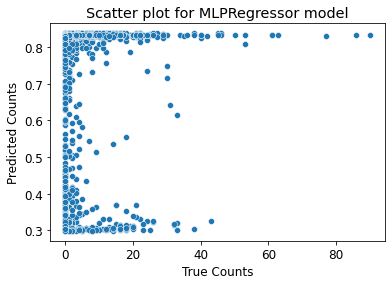

In [60]:
sns.scatterplot(T4_test_label, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

The best model is Multilayer Perceptron
| Evaluation Metric                 |     Score |
|:---------------------------------|----------:|
| RMSE                              |  1.546967 |
| Pearson Correlation Coefficient  |  0.263546 |
| R2                                |  0.069456 |
| Spearman Correlation Coefficient |  0.321409 |


## The regression model of T6 cell

### A. Ordinary Least Squares (OLS) regression

{'copy_X': True, 'fit_intercept': True, 'normalize': False}


In [61]:
# Create a linear regression model
model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
# Fitting the model
model.fit(train_dataset, T6_train_label)
y_pred = model.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T6_test_label)

RMSE:  17.036641422002816
Pearson Correlation Coefficient:  0.3379032459455069
R2:  0.11417860362050973
Spearman Correlation Coefficient:  0.3656012669958427


### B. Support Vector Regression

Best parameters:  {'C': 100, 'kernel': 'linear'}

In [62]:
svr = SVR(C=100, epsilon=0.1,kernel='linear')
svr.fit(train_dataset, T6_train_label)
y_pred = svr.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T6_test_label)

RMSE:  17.250603596969498
Pearson Correlation Coefficient:  0.3293144056136836
R2:  0.10844797774469371
Spearman Correlation Coefficient:  0.36672220655812093


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

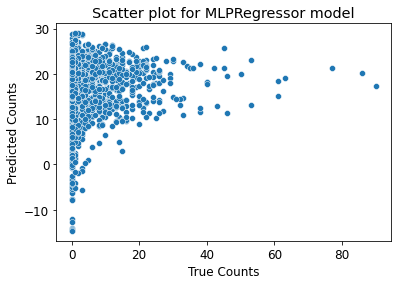

In [63]:
sns.scatterplot(T4_test_label, y_pred).set(title = 'Scatter plot for MLPRegressor model')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

### C. Multilayer Perceptron (MLP)

Best parameters:  {'activation': 'relu', 'batch_size': 4, 'learning_rate': 'adaptive'}

In [64]:
# Define a multi-layer perceptron regression model
model_MLPRegressor = MLPRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', batch_size=4, learning_rate_init=0.001)


# Training models
mlp.fit(train_dataset, T6_train_label)

# Tr# Predict the results of the test set
y_pred = mlp.predict(third_fold_Feature_dataset)
getAllmertic(y_pred,T6_test_label)

RMSE:  17.211287181433907
Pearson Correlation Coefficient:  0.30816125810376876
R2:  0.09496336099609759
Spearman Correlation Coefficient:  0.2962422034727264


The best model is Support Vector Regression:
| Evaluation Metric                 |     Score |
|:---------------------------------|----------:|
| RMSE                              | 17.250604 |
| Pearson Correlation Coefficient  |  0.329314 |
| R2                                |  0.108448 |
| Spearman Correlation Coefficient |  0.366722 |


# **Question No. 3 (Using Convolutional Neural Networks) [40 Marks]**

a. Use a **convolutional neural network (in PyTorch)** to solve this problem in much the same was
as in **part (ii) of Question (2)**. You are to develop an architecture of the neural network that
takes an image directly as input and produces a count as the output corresponding to the
total number of cells. You are free to choose any network structure as long as you can show
that it gives good performance. 

Report your results on the test examples by **plotting the scatter plot** between true and predicted counts on the test data. Also, report your results in
terms of **RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score**. You will be evaluated on the design of your machine learning model and final performance metrics. Try to get the best test performance you can. Please include
convergence plots in your submission showing how does loss change over training epochs.
[20 Marks]

Visualisation of the number of images per class

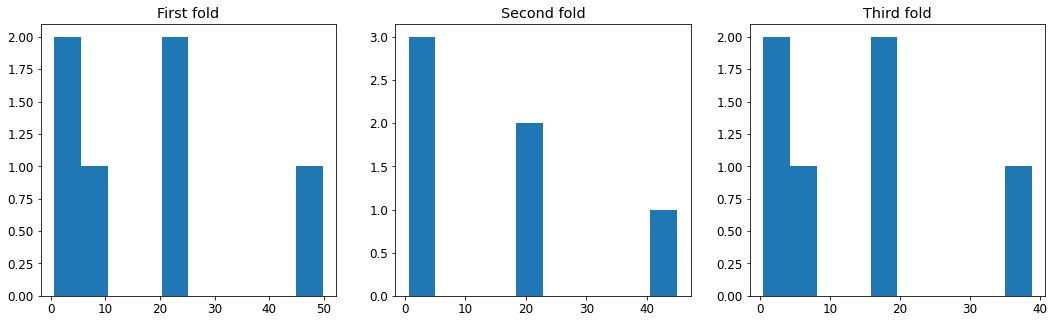

In [65]:
first_fold_Y_mean = first_fold_Y.mean()
second_fold_Y_mean = second_fold_Y.mean()
third_fold_Y_mean = third_fold_Y.mean()

# Create a graph with three subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

ax[0].hist(first_fold_Y_mean)
ax[0].set_title('First fold')
ax[1].hist(second_fold_Y_mean)
ax[1].set_title('Second fold')
ax[2].hist(third_fold_Y_mean)
ax[2].set_title('Third fold')

# Display graphics
plt.show()

The training and test sets have essentially the same distribution, but the validation set is not quite the same, so it is more important to consider the metrics of the training set when choosing the optimal model.

Common functions

In [66]:
from torch.utils.data import TensorDataset

# Convert datasets to DataLoader format
def get_data_loader(dataset, label, batch_size, shuffle):
    dataset = torch.tensor(dataset, dtype=torch.float)
    label = torch.tensor(label)
    dataset = TensorDataset(dataset, label)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle)
    return data_loader

# Processing results
def processResult(y_pred):
    for i in range(len(y_pred)):
        y_pred[i] = y_pred[i][0]
    y_pred = np.array(y_pred)
    return y_pred


def draw_loss(loss_list_train, loss_list,title):
    # Preparation of data
    x = range(len(loss_list_train))
    y1 = loss_list_train
    if len(loss_list) > len(loss_list_train):
        y2 = loss_list[:len(loss_list) - 1]
    else:
        y2 = loss_list
    # Create a canvas
    plt.figure(figsize=(8, 4))

    # Draw the first line
    plt.plot(x, y1, label='Training', color='blue', linewidth=2, linestyle='-')
    # Draw a second line
    plt.plot(x,
             y2,
             label='Development',
             color='red',
             linewidth=2,
             linestyle='--')
    # Set title and axis labels
    plt.title('Average '+title, fontsize=18)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    # Show legend
    plt.legend(fontsize=12)
    # Set grid lines
    plt.grid(True, linestyle='--', alpha=0.5)
    # Display graphics
    plt.show()

### **Data processing**


In [67]:
import cv2

first_fold_X_dataset = []
for i in range(len(first_fold)):
    index = first_fold[i]
    image = X[index]
    first_fold_X_dataset.append(image)

second_fold_X_dataset = []
for i in range(len(second_fold)):
    index = second_fold[i]
    image = X[index]
    second_fold_X_dataset.append(image)

third_fold_X_dataset = []
for i in range(len(third_fold)):
    index = third_fold[i]
    image = X[index]
    third_fold_X_dataset.append(image)

In [68]:
trainloader_all=get_data_loader(first_fold_X_dataset,Total_train,32,True)
devloader_all=get_data_loader(second_fold_X_dataset,Total_dev,32,False)
testloader_all=get_data_loader(third_fold_X_dataset,Total_test,32,False)

C:\Users\hongj\AppData\Local\Temp/ipykernel_7456/378462974.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  dataset = torch.tensor(dataset, dtype=torch.float)


### **Model construction**

The model is based on the CNN model in the courseware, and after training on the most basic version of the structure, the results obtained for the model on the test dataset are

| Metric                         | Value                 |
|--------------------------------|-----------------------|
| RMSE                           | 52.729327753276074    |
| Pearson Correlation Coefficient | 0.4871101734790987    |
| R2                              | 0.2372763211068376    |
| Spearman Correlation Coefficient| 0.5015167116816542    |

It can be seen that the result is not satisfactory.

It has more convolutional layers than the original version and also adds a Dropout layer, which helps prevent overfitting and improves the generalisation of the model. Before adding the Dropout layer there was a large variation in the loss. At the same time I tried adding three large convolutional layers (i.e. multiple layers in one layer), and then the structure was more complex, resulting in an inability to lose final convergence. So keeping fewer layers would give better results.

In [69]:
# Convolutional neural network
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # three Conv2d layers
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(
            
            # The dropout layer helps prevent overfitting
            nn.Dropout(0.1),
            nn.Linear(256 * 16 * 16,256 * 4),
            nn.Dropout(0.5),
            nn.Linear(256 * 4,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes))
        
    def forward(self, x):
      # The dimensions of the data need to be rearranged (permute) to fit the input requirements of PyTorch.
        out = x.permute(0, 3, 1, 2)
        out = self.layer1(out)
        out=out.reshape(out.size(0), 64 * 64 * 16)
        out = self.layer2(out)

        # Output a continuous value
        return out[:,-1][:]

**Set Loss and Optimizer, and creat a model**


Loss function: The MSE loss function is a widely used regression loss function that measures the square of the mean difference between the predicted and true values of a model. In the total cell count prediction task, the objective of the model is to predict the total number of cells in a picture, which is a regression problem and therefore requires the use of the MSE loss function.

Optimizer: This is because adam is an adaptive learning rate method that automatically adjusts the learning rate for each parameter, so that the learning rate can be optimised for different parameters. This speeds up convergence.

In the following models, these loss and optimizer will be applied.

In [70]:
num_classes = 1
# model = ConvNet(num_classes)
model = ConvNet(num_classes)

# Load model parameters
model.load_state_dict(torch.load('model/I_part_30.ckpt'))

# Hyper parameters
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 0.01

# Loss and optimizer
criterion = nn.MSELoss()  # Using the mean square error loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### **The training process**

Because the training process is similar, only the training process of one neural network is shown in this section and the rest is removed

In [71]:
# # Train the model
# these are the lists to store the loss values for plotting
loss_list_train=[3336187.3394224877, 3664.6760577033547, 3672.2275211109836, 3400.6373165355008, 3077.513884899663, 2708.5514646043966, 2340.518695906097, 2014.3168460621553, 1760.4569666245404, 1593.8076414220473, 1496.5231377096736, 1448.6012989118988, 1428.6812675326478, 1423.288948208678, 1424.1517193364161, 1429.746509178012, 1435.1160646326402, 1440.6805777456245, 1444.7552120732325, 1447.851001664704, 1451.6121211332434, 1454.4413401285808, 1453.752951079724, 1455.8763845107135, 1451.6093565996955, 1437.6697489420574, 1442.2870181214575, 1442.633471919041, 1443.881300982307, 1442.4209738338695]
loss_list=[1605158.3990098485, 1771.0932835992778, 1773.0225622788914, 1641.7762212213481, 1486.6434187979069, 1309.7053395397259, 1133.1010943718677, 976.3796447178103, 854.3106487921949, 774.3230926225771, 727.9754952484707, 705.5566324198021, 696.7021681587651, 694.8805291517725, 695.9825486956902, 699.2172570138607, 702.224369696851, 705.1920384101148, 707.3491977475724, 708.9586419879265, 710.8183839186182, 712.1651972644734, 711.8055649523465, 712.7403431298598, 710.6425105400805, 704.0238932483601, 706.2654037475586, 706.3771932350015, 707.0209851534861, 706.1704913445238, 473.33557323285726]
rmse_list=[1832.1176779149614, 60.6686190043888, 60.738014933888344, 58.45002399013574, 55.60268134027941, 52.161659452657126, 48.4873118403901, 44.98051647729269, 42.048877981666095, 40.00725917011135, 38.76603565934989, 38.14063857369576, 37.87881545868527, 37.80913754536243, 37.82242037846072, 37.898226892294936, 37.97059400517549, 38.045090516271884, 38.09953955352795, 38.14080806888647, 38.19067329677138, 38.22813558654155, 38.21920446721912, 38.24724793989816, 38.1911225723141, 38.0069435342905, 38.067867545857844, 38.07228278564265, 38.08847125584911, 38.06912760161713]
pcc_list=[0.029492819344187654, -0.11355100305206231, -0.13112206454229555, -0.010996935203287532, 0.11069713518053707, 0.23490004270934337, 0.35761422140530486, 0.4682378376744903, 0.5544064919326316, 0.6101045137720672, 0.6409730890410328, 0.6552570089837813, 0.6609795431457784, 0.662739061722158, 0.6629034728993808, 0.6619216242552719, 0.6610495526893465, 0.6601066240146031, 0.6594757290872201, 0.6589646619398275, 0.6584284801959632, 0.658195889897122, 0.6587912943202532, 0.6584081733010994, 0.6595855012591566, 0.662930992242206, 0.6620434211841111, 0.6621634949842056, 0.6621410104535942, 0.6622801294275662]
r2_list=[0.0008698263928688895, 0.012893830294129464, 0.01719299580983392, 0.00012093258386530459, 0.012253855737178099, 0.055178030064851336, 0.1278879313513224, 0.21924667263008232, 0.30736655829704707, 0.3722275177250505, 0.41084650087480373, 0.4293617478223712, 0.43689395645720197, 0.4392230639323664, 0.43944101438206007, 0.43814023665673735, 0.4369865111107851, 0.43574075506795656, 0.4349082372551205, 0.43423442568547116, 0.4335280635331659, 0.4332218294774643, 0.4340059694721545, 0.4335013226696905, 0.43505303347129287, 0.43947750047523576, 0.4383014915331623, 0.43846049408969806, 0.43843071772450676, 0.43861496983459386]
corr_list=[0.11428156919373848, -0.08416751767098471, -0.13593968724459038, -0.0033589920670464594, 0.11096292912088015, 0.23833812143397992, 0.3559441758200917, 0.4532387942266348, 0.5491199426543073, 0.6082541590716672, 0.6397774524582132, 0.6555766713041342, 0.6636925909257818, 0.6661034418958529, 0.6657483027267093, 0.6635657896561503, 0.6617420476873082, 0.6595618797368684, 0.6576445218870616, 0.6558406507936069, 0.6535329862573894, 0.651683042732866, 0.6507181761856549, 0.6487671225362157, 0.6488099956512339, 0.6518491934539351, 0.6498423292478956, 0.6492667614400702, 0.6490862699987864, 0.6477410769776754]
dev_rmse_lsit=[79.93555416678498, 68.42784601664472, 69.27930831234048, 69.83061858986233, 68.37084738435631, 65.2073657453438, 60.91256493492111, 56.17909036370729, 51.84044254790562, 48.553024625631316, 46.47137138338028, 45.26958853680807, 44.729419484730954, 44.65148256568819, 44.8352984527347, 45.132125417441564, 45.50947423307781, 45.9013757359171, 46.30816988556496, 46.714366892860475, 47.07143554753948, 47.35578106265748, 47.662410119750035, 47.88557540678037, 48.161555859588454, 48.59365084714979, 48.977713075235485, 49.317246968617766, 49.719224187157906, 49.901008879344076]
dev_pcc_list=[-0.4713114548049428, -0.3215621049032535, -0.23416894066876123, -0.08894097188039571, 0.13525948246179734, 0.3869556984944317, 0.558241523695265, 0.6369738705594526, 0.6683422165746434, 0.6818685383395826, 0.688869396947458, 0.6937561670825648, 0.69814943266324, 0.7025842879793179, 0.7070805580989628, 0.7116980113540508, 0.7164235606209521, 0.7212234254151052, 0.7259482841874527, 0.7305221851346103, 0.7349680561225728, 0.7390910513740458, 0.7431287543496519, 0.7467244671379742, 0.7502625406275406, 0.7535751715811093, 0.7571418977969089, 0.7614485796972751, 0.7628760738223131, 0.7665509985283119]
dev_r2_list=[0.22213448743035163, 0.103402187309811, 0.05483509277392982, 0.00791049647902934, 0.018295127595833263, 0.14973471259731352, 0.31163359877761115, 0.40573571177549034, 0.4466813184559076, 0.46494470357735884, 0.4745410460507544, 0.4812976193650916, 0.4874126303280039, 0.49362468171540513, 0.49996291564154066, 0.5065140593653106, 0.5132627182128031, 0.5201632293674978, 0.5270009113147066, 0.5336626629738459, 0.5401780435205933, 0.5462555822211925, 0.5522403455412652, 0.5575974298224916, 0.562893879868892, 0.5678755392234983, 0.5732638533995048, 0.5798039395229975, 0.5819799040105473, 0.587600433344752]
dev_corr_list=[-0.6038506181945643, -0.4580362885443736, -0.26185387311292385, -0.010901268267037665, 0.21313862162568858, 0.42501628806945824, 0.5810692639227252, 0.664458751351268, 0.7136069639818883, 0.734910447737032, 0.7398874112176835, 0.7420419192727732, 0.7443091762172582, 0.7470269876218752, 0.7499494254319005, 0.7531073351579564, 0.7565522387667282, 0.7601997502855279, 0.7638198623261924, 0.7674803510157293, 0.7712477742298238, 0.7747014943754299, 0.7780732362659981, 0.7810814161968029, 0.7841975074885467, 0.7871929068381437, 0.7904051227488083, 0.7932306197466878, 0.7959796228558039, 0.7976794411022363]

# for epoch in range(num_epochs):
#     loss_sum=0
#     time=0
#     result=[]
#     for i, (images, labels) in enumerate(trainloader):
#         images = images
#         labels = labels
#         # Forward pass
#         outputs = model(images)
#         result=result+outputs.tolist()
#         labels=labels.float()
#         # print(outputs)
#         loss = criterion(outputs, labels)
#         loss_sum=loss_sum+loss.item()
#         time=time+1
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # print("training average loss",loss_sum/ time)
#     print ('Epoch [{}/{}], Step [{}/{}], Training Average Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, epoch, loss_sum/ time))
#     loss_list_train.append(loss_sum/ time)
#     # Save the model checkpoint
#     result=np.array(result)
#     rmse,pcc,r2,corr=getAllmertic(result,Total_train_list)
#     rmse_list.append(rmse)
#     pcc_list.append(pcc)
#     r2_list.append(r2)
#     corr_list.append(corr)
#     torch.save(model.state_dict(), 'I_part_model_'+str(epoch)+'_i.ckpt')
#     # # Test the model
#     model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
#     result=[]
#     with torch.no_grad():
#         loss_sum_dev=0
#         for images, labels in devloader:
#             images = images
#             labels = labels
#             outputs = model(images)
#             labels=labels.float()
#             loss = criterion(outputs, labels)
#             loss_sum_dev=loss_sum+loss.item()
#             time=time+1
#             result=result+outputs.tolist()
#         print ('Epoch [{}/{}], Step [{}/{}], Development Average Loss: {:.4f}' 
#                    .format(epoch+1, num_epochs, i+1, epoch, loss_sum_dev/ time))
#         loss_list.append(loss_sum_dev/ time)
#         result=np.array(result)
#         dev_rmse,dev_pcc,dev_r2,dev_corr=getAllmertic(result,Total_dev)
#         dev_rmse_lsit.append(dev_rmse)
#         dev_pcc_list.append(dev_pcc)
#         dev_r2_list.append(dev_r2)
#         dev_corr_list.append(dev_corr)
#         print("==============================================================================")

The best model:

| Dataset      | Epoch | Step | Average Loss | RMSE          | Pearson Correlation Coefficient | R2                | Spearman Correlation Coefficient |
|--------------|-------|------|--------------|---------------|---------------------------------|------------------|----------------------------------|
| Training     | 30/30 | 51/29 | 1442.4210    | 38.0691276016 | 0.6622801294                    | 0.4386149698     | 0.6477410769                      |
| Development  | 30/30 | 51/29 | 706.1705     | 49.9010088793 | 0.7665509985                    | 0.5876004333     | 0.7976794411                      |



**Visualisation of loss_list_dev and loss_list_train and other metrics**

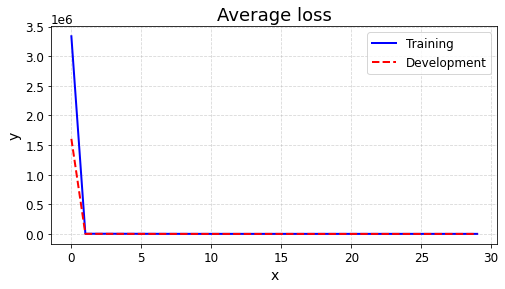

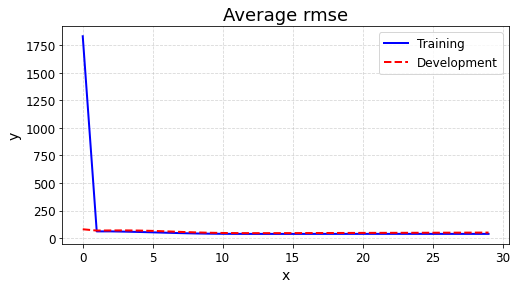

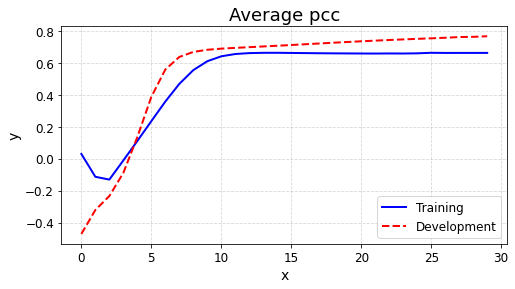

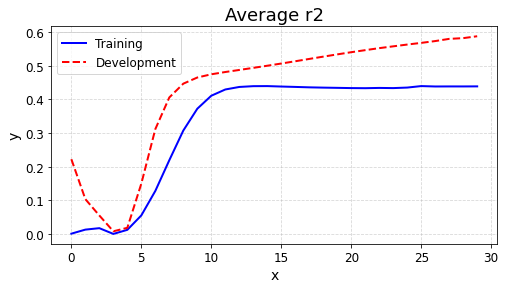

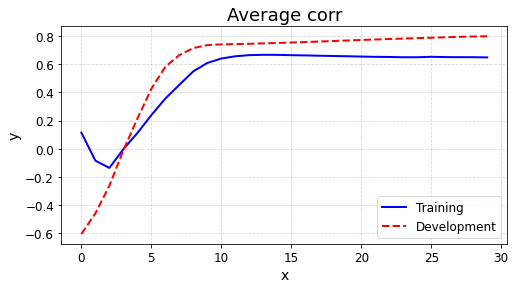

In [72]:
draw_loss(loss_list_train,loss_list,"loss")
draw_loss(rmse_list,dev_rmse_lsit,"rmse")
draw_loss(pcc_list,dev_pcc_list,"pcc")
draw_loss(r2_list,dev_r2_list,"r2")
draw_loss(corr_list,dev_corr_list,"corr")

With the variation of these indicators, I choose the model for the final round

### **Testing by test dataset**

In [73]:
model.eval(
)  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
outputs_list = []
loss_list_test = []
with torch.no_grad():
    loss_sum_dev = 0
    for images, labels in testloader_all:
        images = images
        labels = labels
        outputs = model(images)
        labels = labels.float()
        loss = criterion(outputs, labels)
        outputs_list = outputs_list + outputs.tolist()
outputs_list=np.array(outputs_list)
getAllmertic(outputs_list, Total_test)


RMSE:  59.52165072210956
Pearson Correlation Coefficient:  0.6976313156477643
R2:  0.4866894525724305
Spearman Correlation Coefficient:  0.7301780214097925


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

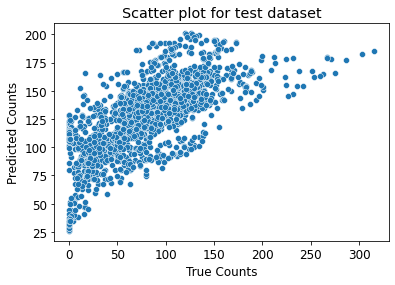

In [74]:
outputs_list.tolist()
sns.scatterplot(Total_test, outputs_list).set(title = 'Scatter plot for test dataset')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

In [75]:
model.eval(
)  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
outputs_list_train = []
loss_list_test = []
with torch.no_grad():
    loss_sum_dev = 0
    for images, labels in trainloader_all:
        images = images
        labels = labels
        outputs = model(images)
        labels = labels.float()
        loss = criterion(outputs, labels)
        outputs_list_train = outputs_list_train + outputs.tolist()

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

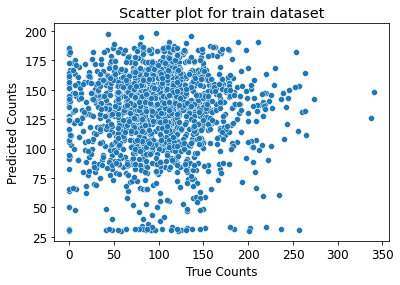

In [76]:
sns.scatterplot(Total_train, outputs_list_train).set(title = 'Scatter plot for train dataset')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

In [77]:
model.eval(
)  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
outputs_list_dev = []
loss_list_test = []
with torch.no_grad():
    loss_sum_dev = 0
    for images, labels in devloader_all:
        images = images
        labels = labels
        outputs = model(images)
        labels = labels.float()
        loss = criterion(outputs, labels)
        outputs_list_dev = outputs_list_dev + outputs.tolist()

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Counts')

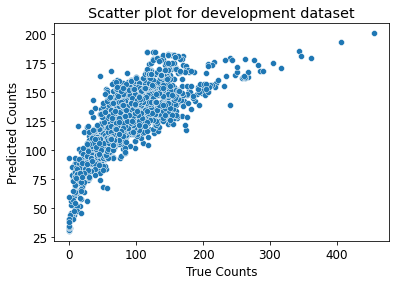

In [78]:
sns.scatterplot(Total_dev, outputs_list_dev).set(title = 'Scatter plot for development dataset')
plt.xlabel("True Counts")
plt.ylabel("Predicted Counts")

## **Question 3 part 2**

First I consider predicting the number of cells and the total number of cells in a model for six categories

For this model, I removed one convolutional layer to reduce the complexity of the model, but optimized the fully connected layer.

### **Data processing**

In [79]:
# Append Series to the end of a DataFrame
sum_by_row.name="total"
df = Y.join(sum_by_row)
# Re-segmentation
first_fold_Y_al = df.loc[first_fold]
second_fold_Y_al = df.loc[second_fold]
third_fold_Y_al = df.loc[third_fold]
first_fold_Y_al=first_fold_Y_al.values.tolist()
second_fold_Y_al=second_fold_Y_al.values.tolist()
third_fold_Y_al=third_fold_Y_al.values.tolist()

In [80]:
first_fold_Y_al_list=first_fold_Y_al
first_fold_Y_al=torch.tensor(first_fold_Y_al)
first_fold_X_dataset=torch.tensor(first_fold_X_dataset, dtype=torch.float)
dataset = TensorDataset(first_fold_X_dataset, first_fold_Y_al)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
devloader=get_data_loader(second_fold_X_dataset,second_fold_Y_al,32,False)
testloader=get_data_loader(third_fold_X_dataset,third_fold_Y_al,32,False)

In [81]:
def plot_s(df,type,result):
    sns.scatterplot(df, result)
    plt.xlabel(type+" True Counts")
    plt.ylabel(type+" Predicted Counts")
    plt.show()

### **Model construction**

In [82]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Calculate the input size of the fully connected layer
        input_size = 64 // (2**2) 
        self.fc = nn.Sequential(
            nn.Linear(input_size * input_size * 64, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [83]:
loss_list_train=[6863.566860423369, 684.3099668914197, 608.780424230239, 671.7198881261489, 639.2532193053003, 633.1210048899931, 640.1341430065679, 627.184211880553, 657.4350588929419, 605.8086184333353, 651.8208854525697, 599.7867606667911, 673.7168420529833, 625.3006216310987, 604.7759157068589, 595.7534719728956, 642.2357841940487, 741.8213740330117, 589.5564512365005, 633.2448856129366, 785.2008879418466, 615.3546627269071, 694.9327344707414, 656.8214422487745, 736.0247928394991, 589.7780371273266, 593.3252650242226, 603.8537298464307, 614.647554285386, 720.0574099970798] 
loss_list=[3306.7602671497275, 332.98275288995706, 297.3990536095961, 327.80231202323483, 313.48274374907874, 310.52781115837814, 314.0841581236641, 308.09331094993735, 322.7633743286133, 298.1536419706525, 320.408813908415, 295.51021223248176, 331.59309689503795, 308.1984602010475, 298.2952770017228, 293.77227675239993, 316.5646250023032, 364.5750110554245, 291.98974594979916, 313.4642642039173, 389.67935051108304, 303.5121704677366, 342.3837671819723, 324.8412515892173, 361.6510686334574, 291.03907768681364, 294.6115257695036, 297.60708042360704, 306.3216391509434, 354.12980212805405, 397.3289341045793]


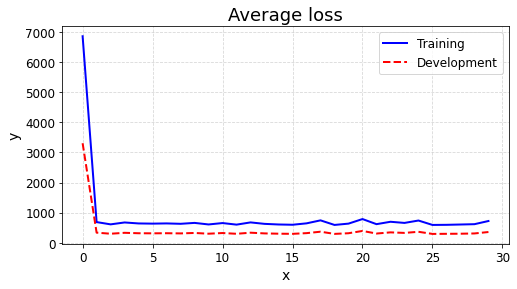

In [84]:
draw_loss(loss_list_train,loss_list,"loss")

The models from the final round are taken according to their performance in the model validation set.

| Metric                          | Value          |
|---------------------------------|----------------|
| Training Average Loss           | 720.0574       |
| Development Average Loss        | 354.1298       |
| RMSE                            | 102.7851       |
| Pearson Correlation Coefficient | 0.5901         |
| R²                              | 0.3482         |
| Spearman Correlation Coefficient| 0.6543         |


In [85]:
num_classes=7
learning_rate = 0.001

# Create a model
model = ConvNet(num_classes)

# Load model parameters
model.load_state_dict(torch.load('model/Part2_all_model.ckpt'))
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### **Testing by test dataset**

In [86]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
outputs_list=[]    
with torch.no_grad():
        for images, labels in testloader:
            images = images
            labels = labels
            outputs = model(images)
            labels=labels.float()
            loss = criterion(outputs, labels)
            outputs_list=outputs_list+outputs.tolist()

In [87]:
test_result=df.iloc[third_fold]
train_result=df.iloc[first_fold]
dev_result=df.iloc[second_fold]

In [88]:
T1_test = test_result['neutrophil'].values.tolist()
T2_test = test_result['epithelial'].values.tolist()
T3_test = test_result['lymphocyte'].values.tolist()
T4_test = test_result['plasma'].values.tolist()
T5_test = test_result['eosinophil'].values.tolist()
T6_test = test_result['connective'].values.tolist()
T1_train=train_result['neutrophil'].values.tolist()
T2_train=train_result['epithelial'].values.tolist()
T3_train=train_result['lymphocyte'].values.tolist()
T4_train=train_result['plasma'].values.tolist()
T5_train=train_result['eosinophil'].values.tolist()
T6_train=train_result['connective'].values.tolist()
T1_dev=dev_result['neutrophil'].values.tolist()
T2_dev=dev_result['epithelial'].values.tolist()
T3_dev=dev_result['lymphocyte'].values.tolist()
T4_dev=dev_result['plasma'].values.tolist()
T5_dev=dev_result['eosinophil'].values.tolist()
T6_dev=dev_result['connective'].values.tolist()

In [89]:
def getAllType(outputs_list):
  total_pred=[]
  T1_pred=[]
  T2_pred=[]
  T3_pred=[]
  T4_pred=[]
  T5_pred=[]
  T6_pred=[]
  for item in outputs_list:
      T1_pred.append(item[0])
      T2_pred.append(item[1])
      T3_pred.append(item[2])
      T4_pred.append(item[3])
      T5_pred.append(item[4])
      T6_pred.append(item[5])
      total_pred.append(item[6])

  T1_pred=np.array(T1_pred)
  T2_pred=np.array(T2_pred)
  T3_pred=np.array(T3_pred)
  T4_pred=np.array(T4_pred)
  T5_pred=np.array(T5_pred)
  T6_pred=np.array(T6_pred)
  total_pred=np.array(total_pred)
  return T1_pred,T2_pred,T3_pred,T4_pred,T5_pred,T6_pred,total_pred
T1_pred,T2_pred,T3_pred,T4_pred,T5_pred,T6_pred,total_pred=getAllType(outputs_list)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


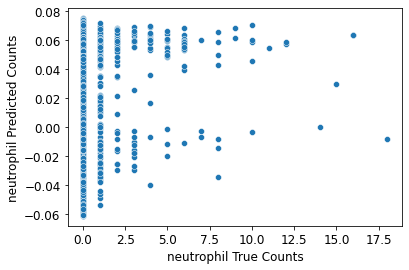

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


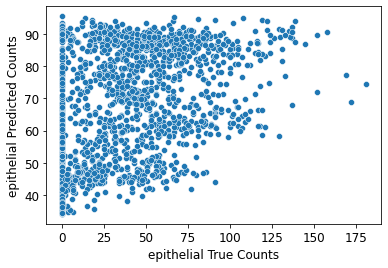

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


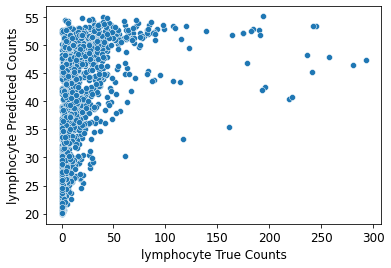

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


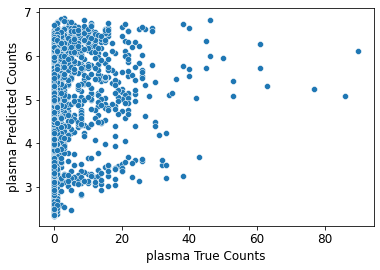

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


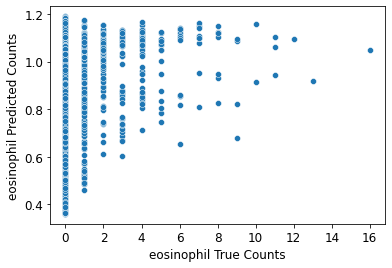

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


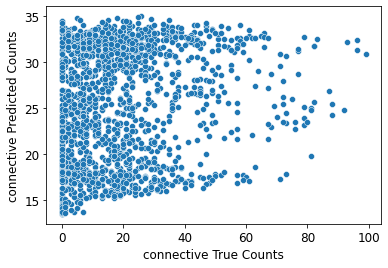

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


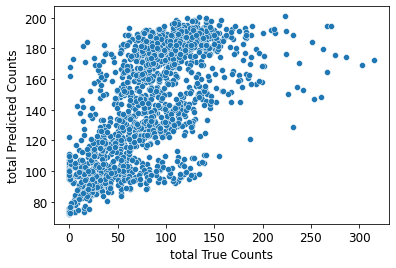

In [90]:
plot_s(T1_test,"neutrophil",T1_pred)
plot_s(T2_test,"epithelial",T2_pred)
plot_s(T3_test,"lymphocyte",T3_pred)
plot_s(T4_test,"plasma",T4_pred)
plot_s(T5_test,"eosinophil",T5_pred)
plot_s(T6_test,"connective",T6_pred)
plot_s(Total_test,"total",total_pred)

In [91]:
print("The Predicted result of T1 is:")
getAllmertic(T1_pred,T1_test)
print("=====================================")
print("The Predicted result of T2 is:")
getAllmertic(T2_pred,T2_test)
print("=====================================")
print("The Predicted result of T3 is:")
getAllmertic(T3_pred,T3_test)
print("=====================================")
print("The Predicted result of T4 is:")
getAllmertic(T4_pred,T4_test)
print("=====================================")


The Predicted result of T1 is:
RMSE:  1.6889027427012022
Pearson Correlation Coefficient:  0.19163097985333882
R2:  0.03672243243955075
Spearman Correlation Coefficient:  0.25437254141802973
The Predicted result of T2 is:
RMSE:  42.206590923680714
Pearson Correlation Coefficient:  0.4136943622481296
R2:  0.17114302535588669
Spearman Correlation Coefficient:  0.41436136568053694
The Predicted result of T3 is:
RMSE:  34.98858172308801
Pearson Correlation Coefficient:  0.4180607061941634
R2:  0.17477475406356263
Spearman Correlation Coefficient:  0.6783694034432722
The Predicted result of T4 is:
RMSE:  8.445235772017396
Pearson Correlation Coefficient:  0.21212253609126944
R2:  0.04499597031779191
Spearman Correlation Coefficient:  0.3973602979265713


In [92]:
print("The Predicted result of T5 is:")
getAllmertic(T5_pred,T5_test)
print("=====================================")
print("The Predicted result of T6 is:")
getAllmertic(T6_pred,T6_test)
print("=====================================")
print("The Predicted result of total is:")
getAllmertic(total_pred,Total_test)
print("=====================================")

The Predicted result of T5 is:
RMSE:  1.553872686003732
Pearson Correlation Coefficient:  0.27652687350275434
R2:  0.0764671117692083
Spearman Correlation Coefficient:  0.3211564246935115
The Predicted result of T6 is:
RMSE:  18.951352770412075
Pearson Correlation Coefficient:  0.2032072429443935
R2:  0.04129318358506176
Spearman Correlation Coefficient:  0.23274054302100822
The Predicted result of total is:
RMSE:  72.00280922137169
Pearson Correlation Coefficient:  0.6637984559476636
R2:  0.4406283901185023
Spearman Correlation Coefficient:  0.6957837850240872


In [93]:
model.eval()
outputs_list=[]    
with torch.no_grad():
        for images, labels in trainloader:
            images = images
            labels = labels
            outputs = model(images)
            labels=labels.float()
            loss = criterion(outputs, labels)
            outputs_list=outputs_list+outputs.tolist()

In [94]:
T1_pred,T2_pred,T3_pred,T4_pred,T5_pred,T6_pred,total_pred=getAllType(outputs_list)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


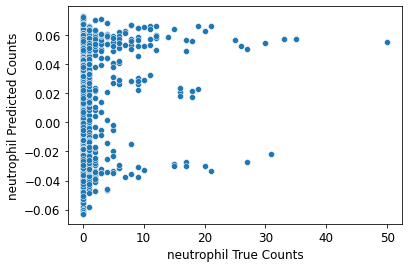

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


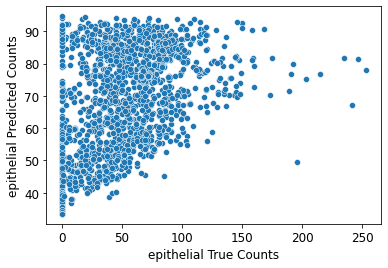

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


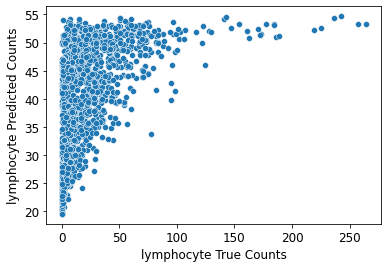

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


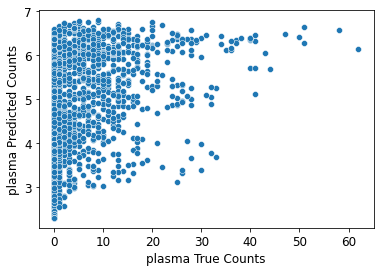

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


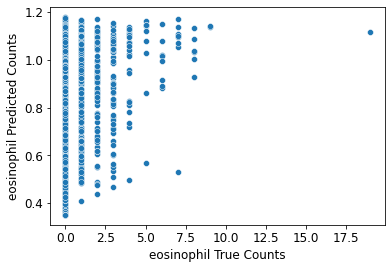

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


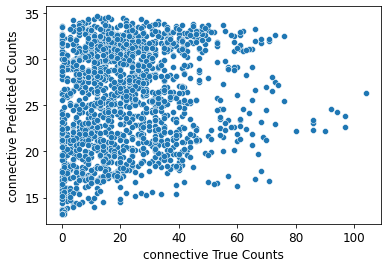

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


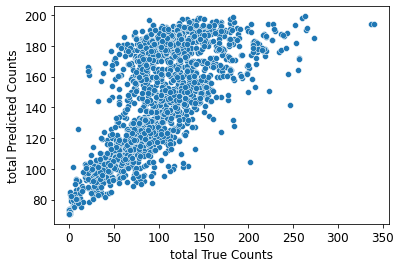

In [95]:
plot_s(T1_train,"neutrophil",T1_pred)
plot_s(T2_train,"epithelial",T2_pred)
plot_s(T3_train,"lymphocyte",T3_pred)
plot_s(T4_train,"plasma",T4_pred)
plot_s(T5_train,"eosinophil",T5_pred)
plot_s(T6_train,"connective",T6_pred)
plot_s(Total_train,"total",total_pred)

In [96]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
outputs_list=[]    
with torch.no_grad():
        for images, labels in devloader:
            images = images
            labels = labels
            outputs = model(images)
            labels=labels.float()
            loss = criterion(outputs, labels)
            outputs_list=outputs_list+outputs.tolist()

In [97]:
T1_pred,T2_pred,T3_pred,T4_pred,T5_pred,T6_pred,total_pred=getAllType(outputs_list)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


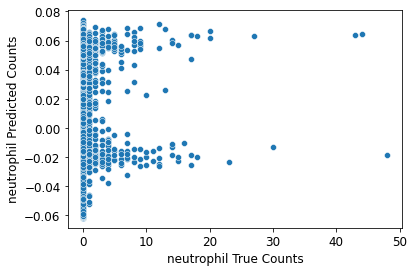

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


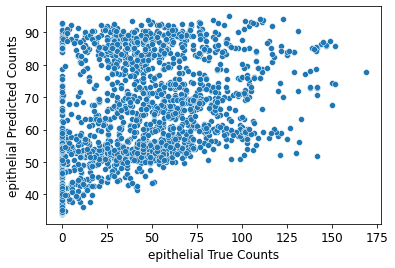

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


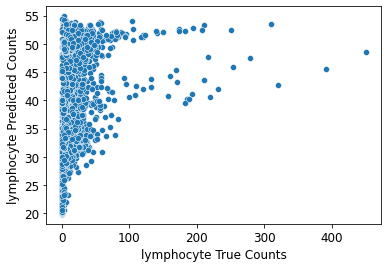

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


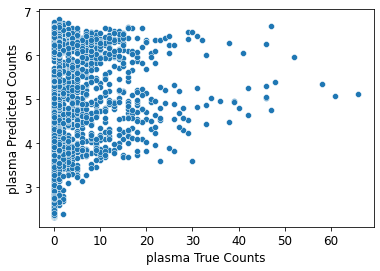

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


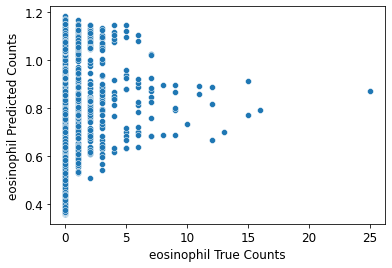

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


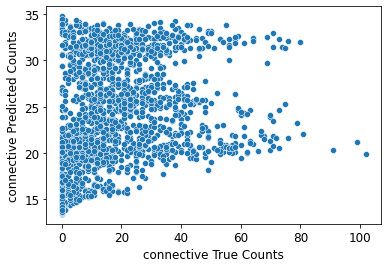

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


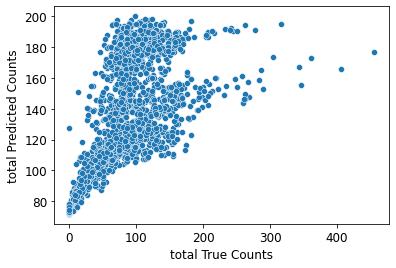

In [98]:
plot_s(T1_dev,"neutrophil",T1_pred)
plot_s(T2_dev,"epithelial",T2_pred)
plot_s(T3_dev,"lymphocyte",T3_pred)
plot_s(T4_dev,"plasma",T4_pred)
plot_s(T5_dev,"eosinophil",T5_pred)
plot_s(T6_dev,"connective",T6_pred)
plot_s(Total_dev,"total",total_pred)

The results for cells in categories 1, 4, 5 and 6 are poor and retraining the model for them could be considered, but judging from the results of the regression model, I don't think the current dataset can support it to achieve higher accuracy

## **The consolidated table**

|        | Metric                 | OLS            | SVC            | MLPRegressor   |Part I model| Part II model|    
|--------|----------------------|----------------|----------------|----------------|----------------|----------------|            
| Total number  | RMSE                 | 38.3844        | 38.6276        | **36.3935**        |59.5216|72.0028|
|        | Pearson              | 0.6819         | 0.6421         | **0.7186**         |0.6976|0.6638|
|        | R2                   | 0.4650         | 0.4123         | **0.5164**         |0.4867|0.4406|
|        | Spearman             | 0.7235         | 0.6842         | **0.7485**         |0.7302|0.6958|
| T1     | RMSE                 | 1.7059         | 1.6998         | 1.7294         |      |**1.6889**|
|        | Pearson              | 0.2022         | 0.1223         | **0.2583**         |      |0.1916|
|        | R2                   | 0.0409         | 0.01497        | **0.06671**        |      |0.0367|
|        | Spearman             | 0.2199         | 0.1748         | 0.2541         |      |**0.2543**|
| T2     | RMSE                 | **1.7102**         | 30.2804        | 31.4558        |      |42.2065|
|        | Pearson              | 0.1983         | **0.4758**         | 0.4282         |      |0.4137|
|        | R2                   | 0.0393         | **0.2264**         | 0.1834         |      |0.1711|
|        | Spearman             | 0.2165         | **0.5037**         | 0.4025         |      |0.4144|
| T3     | RMSE                 | 27.6214        | 27.6811        | **26.4689**        |      |34.9889|
|        | Pearson              | 0.3924         | 0.3745         | **0.4577**         |      |0.4181|
|        | R2                   | 0.1540         | 0.1402         | **0.2095**         |      |0.1748|
|        | Spearman             | 0.6262         | 0.6201         | 0.6640         |      |**0.6783**|
| T4     | RMSE                 | 8.7009         | 8.6275         | 8.4572         |      |**8.4452**|
|        | Pearson              | 0.1228         | 0.2174         | **0.2237**         |      |0.2121|
|        | R2                   | 0.0151         | 0.0473         | **0.0501**         |      |0.0450|
|        | Spearman             | 0.3141         | **0.4215**         | 0.3619         |      |0.3974|
| T5     | RMSE                 | 1.5544         | 1.6562         | **1.5470**         |      |1.5539|
|        | Pearson              | 0.2171         | 0.1568         | 0.2635         |      |**0.2765**|
|        | R2                   | 0.0472         | 0.0246         | 0.0695         |      |**0.0765**|
|        | Spearman             | 0.3142         | 0.2329         | **0.3214**         |      |0.3212|
| T6     | RMSE                 | **17.0366**        | 17.2506        | 17.1921        |      |18.9514|
|        | Pearson              | **0.337**          | 0.329          | 0.310          |      |0.2032|
|        | R2                   | 0.114          | **0.1084**         | 0.0960         |      |0.0413|
|        | Spearman             | 0.3656         | **0.3667**         | 0.3060         |      |0.2327|

The comparative plots show that in the regression model, the MLPRegressor outperforms SVC and OLS for most cell classifications, while SVC is more effective than OLS.

The results show that the individual models have an advantage in determining the number of cells, whether they are regression models or neural networks. Because the metrics for each prediction term in part II's model are weaker than those of the regression model, but part I's predictions for overall cell numbers are similar to the optimal regression model, MLPRegressor.

MLPRegressor is the best model for total number, T1 cell number, T3 cell number, T4 cell number.

SVC is the best model for T2 cell number, T6 cell number.

OLS is the best model for T6 cell number.

Part II model is the best for T5 cell number.